In [2]:
import json
import math
import torch
import os
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
# from Earlystop import EarlyStopping
from torch.autograd import grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import datetime
from itertools import product
"""# Exact solution u(x) for the example PDE
we conduct a experiment on solving a IBVP with nonlinear diffusion-reaction equation and boundary condition involving time:
\begin{equation}
\left\{\begin{array}{ll}
u_{t}-\Delta u-u^{2}=f(x, y, t), & \text { in } \Omega \times[0, T] \\
u(x, y, t)=g(x, y, t), & \text { on } \partial \Omega \times[0, T] \\
u(x, y, 0)=h(x, y), & \text { in } \Omega
\end{array}\right.
\end{equation}
where $\Omega=(-1,1)^{2} \subset \mathbb{R}^{2}$. In this test, we give the definition of $f(x,y,t)=\left(\pi^{2}-2\right) \sin \left(\frac{\pi}{2} x\right) \cos \left(\frac{\pi}{2} y\right) e^{-t} - 4 \sin ^{2}\left(\frac{\pi}{2} x\right) \cos \left(\frac{\pi}{2} y\right) e^{-2 t}$ in $\Omega \times[0, T]$, $g(x,y,t)=2 \sin \left(\frac{\pi}{2} x\right) \cos \left(\frac{\pi}{2} y\right) e^{-t}$ on $\partial \Omega \times[0, T]$ and $h(x,y)=2 \sin \left(\frac{\pi}{2} x\right) \cos \left(\frac{\pi}{2} y\right)$ in $\Omega$. And the true solution is $u(x,y,t)=2 \sin \left(\frac{\pi}{2} x\right) \cos \left(\frac{\pi}{2} y\right) e^{-t}$.

# PDE Setup
"""

'''
# I use this to get the shape of the tensor when I debug
old_repr = torch.Tensor.__repr__
def tensor_info(tensor):
    return repr(tensor.shape)[6:] + ' ' + repr(tensor.dtype)[6:] + '@' + str(tensor.device) + '\n' + old_repr(tensor)
torch.Tensor.__repr__ = tensor_info
#'''

os.environ["CUDA_VISIBLE_DEVICES"] = "3,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device=torch.device('cpu')
# TODO: implement cuda

def func_u_sol(xt):
    l = xt.shape[0]
    u = 2 * torch.sin(math.pi / 2 * xt[:, 0, :]) * torch.cos(math.pi / 2 * xt[:, 1, :]) * torch.exp(-xt[:, 2, :])
    return(u)


# We denote spatial coordinates with time as 'xt' and 'x' without

def func_f(xt):
    l = xt.shape[0]
    f = (math.pi ** 2 - 2) * torch.sin(math.pi / 2 * xt[:, 0, :]) * torch.cos(math.pi / 2 * xt[:, 1, :]) * torch.exp(
        -xt[:, 2, :]) - 4 * torch.sin(math.pi / 2 * xt[:, 0, :]) ** 2 * (torch.cos(math.pi / 2 * xt[:, 1, :]) **2)* torch.exp(-xt[:, 2, :])
    return(f)


def func_g(boundary_xt):
    return func_u_sol(boundary_xt)


def func_h(x):
    h = 2 * torch.sin(math.pi / 2 * x[:, 0]) * torch.cos(math.pi / 2 * x[:, 1])
    return h

def func_c(y_output_u):
    return -y_output_u

def func_w(x):  # returns 1 for positions in the domain and 0 otherwise
    lens = x.shape[0]
    w_bool = torch.gt(1 - torch.abs(x[:, 0]), torch.zeros(lens).to(device)) & torch.gt(torch.abs(x[:, 0]), torch.zeros(lens).to(device))
    w_val = torch.where(w_bool, 1 - torch.abs(x[:, 0]) + torch.abs(x[:, 0]), torch.zeros(lens).to(device))
    return (w_val.view(-1, 1))


"""# Domain"""

T0 = 0  # if this is ignored it is always set as T0=0
T = 1

# Set up for a square
up = 1.0
down = -1.0
dim = 2
domain_sample_size =1000  # 8000, 25000
t_mesh_size = 11

boundary_sample_size = domain_sample_size //25

# defining the training domain
x0_domain = torch.Tensor(domain_sample_size, dim).uniform_(down, up)
x0_domain.requires_grad_()

x_domain_train = x0_domain.unsqueeze(2).repeat(1, 1, t_mesh_size)

t = torch.linspace(T0, T, t_mesh_size).unsqueeze(1).unsqueeze(2).view(1, 1, t_mesh_size).repeat(domain_sample_size, 1, 1)
xt_domain_train = torch.cat((x_domain_train, t), dim=1).to(device)


# defining the training boundary
x0_boundary_side = torch.Tensor(boundary_sample_size, dim - 1).uniform_(down, up)
x0_boundary_side.requires_grad_()

x0_boundary_left = torch.cat((torch.ones(x0_boundary_side.size()) * down, x0_boundary_side), 1)
x0_boundary_right = torch.cat((torch.ones(x0_boundary_side.size()) * up, x0_boundary_side), 1)
x0_boundary_down = torch.cat((x0_boundary_side, torch.ones(x0_boundary_side.size()) * down), 1)
x0_boundary_up = torch.cat((x0_boundary_side, torch.ones(x0_boundary_side.size()) * up), 1)

x0_boundary = torch.cat((x0_boundary_left, x0_boundary_right, x0_boundary_down, x0_boundary_up), 0)

x_boundary_train = x0_boundary.unsqueeze(2).repeat(1, 1, t_mesh_size)
xt_boundary_train = torch.cat((x_boundary_train, t[:4*boundary_sample_size, :, :]), dim=1).to(device)

# Validation data Sets
val_domain_size = int(domain_sample_size * 0.3)
val_boundary_size = int(boundary_sample_size * 0.3)

x0_domain_val = torch.Tensor(val_domain_size, dim).uniform_(down, up)
x0_domain_val.requires_grad_()

x_domain_val = x0_domain_val.unsqueeze(2).repeat(1, 1, t_mesh_size)
xt_domain_val = torch.cat((x_domain_val, t[:val_domain_size, :, :]), dim=1).to(device)

# defining the validation boundary
x0_boundary_side = torch.Tensor(val_boundary_size, dim - 1).uniform_(down, up)
x0_boundary_side.requires_grad_()

x0_boundary_left = torch.cat((torch.ones(x0_boundary_side.size()) * down, x0_boundary_side), 1)
x0_boundary_right = torch.cat((torch.ones(x0_boundary_side.size()) * up, x0_boundary_side), 1)
x0_boundary_down = torch.cat((x0_boundary_side, torch.ones(x0_boundary_side.size()) * down), 1)
x0_boundary_up = torch.cat((x0_boundary_side, torch.ones(x0_boundary_side.size()) * up), 1)

x0_boundary = torch.cat((x0_boundary_left, x0_boundary_right, x0_boundary_down, x0_boundary_up), 0)

x_boundary_val = x0_boundary.unsqueeze(2).repeat(1, 1, t_mesh_size)
xt_boundary_val = torch.cat((x_boundary_val, t[:4*val_boundary_size, :, :]), dim=1).to(device)

###################################
xv = xt_domain_train[:, 0, :].clone().detach()
yv = xt_domain_train[:, 1, :].clone().detach()
tv = xt_domain_train[:, 2, :].clone().detach()
xv = xv.requires_grad_(True).to(device)
yv = yv.requires_grad_(True).to(device)
tv = tv.requires_grad_(True).to(device)



xu = xv.clone().detach()
yu = yv.clone().detach()
tu = tv.clone().detach()
xu.requires_grad_(True).to(device)
yu.requires_grad_(True).to(device)
tu.requires_grad_(True).to(device)



X = [xu, yu, tu]
XV = [xv, yv, tv]

x_val = xt_domain_val[:, 0, :].clone().detach().requires_grad_(True).to(device)
y_val = xt_domain_val[:, 1, :].clone().detach().requires_grad_(True).to(device)
t_val = xt_domain_val[:, 2, :].clone().detach().requires_grad_(True).to(device)

###newly added
a1, a2 = torch.cat((torch.ones(1, 1, domain_sample_size, t_mesh_size, 1), torch.zeros(1, 1, domain_sample_size, t_mesh_size, 1)), dim=1), torch.cat((torch.zeros(1, 1, domain_sample_size, t_mesh_size, 1), torch.ones(1, 1, domain_sample_size, t_mesh_size, 1)), dim=1)
a = torch.cat((a1, a2), dim=0).to(device)

# this is meant to be a d-dimensional containing domain_sample_size by t_mesh_size by 1 tensors
b = torch.cat((torch.zeros(1, domain_sample_size, t_mesh_size, 1), torch.zeros(1, domain_sample_size, t_mesh_size, 1)), dim=0).to(device)

x_setup = xv.clone().detach().to(device)
y_setup = yv.clone().detach().to(device)
t_setup = tv.clone().detach().to(device)

xyt_setup = torch.cat((x_setup.unsqueeze(2).view(-1, 1, t_mesh_size), y_setup.unsqueeze(2).view(-1, 1, t_mesh_size), t_setup.unsqueeze(2).view(-1, 1, t_mesh_size)), dim=1)

h = func_h(xyt_setup[:, :, 0]).to(device)
f = func_f(xyt_setup).to(device)
g = func_g(xt_boundary_train.clone().detach().to(device)).unsqueeze(2).to(device)


"""# Defining the Model"""


def init_weights(layer):
    if type(layer) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0)

class generator(torch.nn.Module):  # this makes the u function

    def __init__(self, config):
        super().__init__()
        self.num_layers = config['u_layers']
        self.hidden_dim = config['u_hidden_dim']        
        self.input = torch.nn.Linear(dim+1, self.hidden_dim)
        self.hidden = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.output = torch.nn.Linear(self.hidden_dim, 1)

        self.net = torch.nn.Sequential(*[
            self.input,
            *[torch.nn.ReLU(), self.hidden] * self.num_layers,
            torch.nn.Tanh(),
            self.output
        ])

    def forward(self, x0, y0, t):        
        inp = torch.cat((x0.unsqueeze(2), y0.unsqueeze(2), t.unsqueeze(2)), dim=2)
        x = self.net(inp)
        return x


class discriminator(torch.nn.Module):  # this makes the v function

    def __init__(self, config):
        super().__init__()
        self.num_layers = config['v_layers']
        self.hidden_dim = config['v_hidden_dim']

        self.input = torch.nn.Linear(dim+1, self.hidden_dim)
        self.hidden = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.output = torch.nn.Linear(self.hidden_dim, 1)
        
        self.net = torch.nn.Sequential(*[
            self.input,
            *[torch.nn.ReLU(), self.hidden] * self.num_layers,
            torch.nn.Tanh(),
            self.output
        ])
        
    def forward(self, x0, y0, t):       
        inp = torch.cat((x0.unsqueeze(2), y0.unsqueeze(2), t.unsqueeze(2)), dim=2)
        x = self.net(inp)
        return x


#Serach space based on the WAN Paper
config = {
    'alpha':32768,
    #tune.choice(5**2,5,50,10**2,5*10**2,10**3,5*10**3,10**4,5*10**4,10**5,5*10**5,10**6,5*10**6,10**7]),
    #'gamma': tune.loguniform(1e1, 1e5), #tune.uniform(10, 50),#tune.loguniform(1e1, 1e5),#tune.loguniform(1e3, 1e7),
    'u_layers': 7,
    'u_hidden_dim': 20,
    'v_layers': 7,
    'v_hidden_dim': 50,
    'n1': 10,  # tune.choice([2, 4, 6, 8, 10, 14, 20]),
    'n2': 5,  # tune.sample_from(lambda spec: int(spec.config.n1/2)),
    'u_rate': 0.02, #tune.choice([0.0005,0.001,0.0015,0.003,0.005,0.01,0.02,0.05,0.1]),
    'v_rate': 0.0015, #tune.choice([0.0005,0.001,0.0015,0.003,0.005,0.01,0.02,0.05,0.1]),
    'iteration': 10000,
    'subiteration':10,
    'u_factor': 0.9,#tune.choice([0.7,0.8,0.9,0.95]),
    'v_factor':0.95 #tune.choice([0.7,0.8,0.9,0.95])
}

'''
#Original WAN paper
config = {
    'u_layers': 7,
    'u_hidden_dim': 20,
    'v_layers': 7,
    'v_hidden_dim': 50,
    'n1': 10,  # 2,
    'n2': 5,  # 6, 1
    'u_rate': 0.015,  # 0.00015
    'v_rate': 0.04   # 0.00015
}


#One hyperparameter result
config = {
    'u_layers': 5,
    'u_hidden_dim': 20,
    'v_layers': 6,
    'v_hidden_dim': 16,
    'n1': 10,
    'n2': 6,
    'u_rate': 0.0025703,
    'v_rate': 0.00593051}

#Search Space for the above
config = {
    'u_layers': tune.choice([4, 5, 6, 7, 8]),
    'u_hidden_dim': tune.choice([20, 21, 23]),
    'v_layers': tune.choice([5, 6, 7, 8]),
    'v_hidden_dim': tune.choice([13, 15, 16]),
    'n1': 10,
    'n2': 5,
    'u_rate': tune.loguniform(1e-3, 1e-2),
    'v_rate': tune.loguniform(1e-3, 1e-2)
}
'''

"""# Loss Function"""


def I(y_output_u, y_output_v, XV, X, a=a, b=b,h=h, f=f, c=func_c):

    y_output_u.retain_grad()
    y_output_v.retain_grad()
    phi = y_output_v * func_w(XV[0]).unsqueeze(2).repeat(1, t_mesh_size, 1)
    y_output_u.backward(torch.ones_like(y_output_u).to(device), retain_graph=True)
    du = {}
 
    for i in range(dim):
        du['du_'+str(i)] = X[i].grad
    phi.backward(torch.ones_like(phi).to(device), retain_graph=True)
    dphi = {}
    for i in range(dim+1):
        dphi['dphi_'+str(i)] = XV[i].grad
    s1 = y_output_u[:, -1, :].squeeze(1) * phi[:, -1, :].squeeze(1) - h * phi[:, 0, :].squeeze(1)
    s2 = (T-T0)*(y_output_u * dphi['dphi_2'].unsqueeze(2))/t_mesh_size  # for t does this make sense? 
    s31 = 0
    
    for i,j in product(range(dim), repeat=2):
        s31 += a[i, j, :, :, :] * dphi['dphi_'+str(i)].unsqueeze(2) * du['du_'+str(j)].unsqueeze(2)
    s32 = 0
    for i in range(dim):
        s32 += b[i] * phi * du['du_'+str(i)].unsqueeze(2)
    s3 = (T-T0)*(s31 + s32 + func_c(y_output_u) * y_output_u * phi - f.unsqueeze(2) * phi)/t_mesh_size
    I = torch.sum(s1 - torch.sum(s2 - s3, 1).squeeze(1), 0)
    for i in X:
        i.grad.data.zero_()
    for i in XV:
        i.grad.data.zero_()
    return I

def L_init(y_output_u, h=h):
    return torch.mean((y_output_u[:, 0, :].squeeze(1) - h) ** 2)

def L_bdry(u_net, g=g):
    return torch.mean((u_net(xt_boundary_train[:, 0, :].requires_grad_(True), xt_boundary_train[:, 1, :].requires_grad_(True), xt_boundary_train[:, 2, :].requires_grad_(True)) - g) ** 2)

# def L_bdry(u_net):
#     return torch.mean((u_net(xt_boundary_train[:, 0, :], xt_boundary_train[:, 1, :], xt_boundary_train[:, 2, :]) -
#                        func_g(xt_boundary_train).unsqueeze(2)) ** 2)



def L_init(y_output_u, h=h):
    return torch.mean((y_output_u[:, 0, :].squeeze(1) - h) ** 2)

def L_bdry(u_net, g=g):
    return torch.mean((u_net(xt_boundary_train[:, 0, :].requires_grad_(True), xt_boundary_train[:, 1, :].requires_grad_(True), xt_boundary_train[:, 2, :].requires_grad_(True)) - g) ** 2)

def L_int(y_output_u, y_output_v, XV=XV, X=X):
    # x needs to be the set of points set plugged into net_u and net_v
    return torch.log((I(y_output_u, y_output_v, XV, X)) ** 2) - torch.log(torch.sum(y_output_v ** 2))

def Loss_u(y_output_u, y_output_v, u_net, alpha, gamma):
    return L_int(y_output_u, y_output_v) + gamma * L_init(y_output_u) + alpha * L_bdry(u_net)

def Loss_v(y_output_u, y_output_v):
    return -L_int(y_output_u, y_output_v)

# TODO: identify the best n1, n2 (n2=n1/2) and best alpha and gamma

"""# Training"""


x_mesh = torch.linspace(0, 1, 50, requires_grad=True)
mesh1, mesh2 = torch.meshgrid(x_mesh, x_mesh)
mesh_1= torch.reshape(mesh1, [-1,1])
mesh_2= torch.reshape(mesh2, [-1,1])

t = torch.ones(2500, 1)
xt_test = torch.cat((mesh_1, mesh_2, t), dim = 1).unsqueeze(2)

xt_test.to(device)

def train(config, checkpoint_dir=None):
    n1 = config['n1']
    n2 = config['n2']
    
    iteration=config['iteration']
    nn=config['subiteration']
    
    # neural network models
    u_net = generator(config).to(device)
    v_net = discriminator(config).to(device)
    
    u_net.apply(init_weights)
    v_net.apply(init_weights)
    
    #scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_u, factor=0.5, patience=30)
    #scheduler_v = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_v, factor=0.5, patience=30)

    prediction_u = u_net(xu, yu, tu)
    prediction_v = v_net(xv, yv, tv)

    Loss = 0
    error_mae=10     
    errors=[]
    for k in range(iteration):
        
        # optimizers for WAN
        optimizer_u = torch.optim.Adam(u_net.parameters(), lr=config['u_rate'])
        optimizer_v = torch.optim.Adam(v_net.parameters(), lr=config['v_rate'])
        
        scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_u, factor=config['u_factor'], patience=0)
        scheduler_v = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_v, factor=config['v_factor'], patience=0)
        
        for i in range(n1):
            
            loss_u = Loss_u(prediction_u, prediction_v, u_net, config['alpha'], config['alpha'])
            
            optimizer_u.zero_grad()
            loss_u.backward(retain_graph=True)
            try:
                optimizer_u.step()
            except TypeError:
                print("this opt_u step is wrong")
            scheduler_u.step(loss_u)
            prediction_u = u_net(xu, yu, tu)            
          

        for j in range(n2):
            loss_v = Loss_v(prediction_u, prediction_v)
            
            optimizer_v.zero_grad()
            loss_v.backward(retain_graph=True)
            try:
                optimizer_v.step()
            except TypeError:
                print("this opt_v step is wrong")
                
            scheduler_v.step(loss_v)
            prediction_v = v_net(xv, yv, tv)
#             print('v',k,i,torch.isnan(prediction_v).any()) #sanity check
        
        loss_u = Loss_u(prediction_u, prediction_v, u_net, 1, 1)        #this is to ensure that for our reported losses they are all scaled equally to avoid a bias away from large alpha
        Loss += 0.1*loss_u

        if k % nn == 0:
            #torch.save(u_net.state_dict(), "./net_u.pth")
            #torch.save(v_net.state_dict(), "./net_v.pth")
            print(k, loss_u.data.item(), loss_v.data.item())
            # print('learning rate at %d epoch：%f' % (k, optimizer_u.param_groups[0]['lr']))
            # print('learning rate at %d epoch：%f' % (k, optimizer_v.param_groups[0]['lr']))
            
#             tune.report(loss=Loss.item())
            Loss = 0

            error_test = torch.mean(
                torch.sqrt(torch.square((func_u_sol(xt_domain_train) - prediction_u.data.squeeze(2))))).data
            print("error test " + str(error_test.item()))
            if error_mae>error_test.item():
                error_mae=error_test.item()
            errors.append(error_mae)
            
        if error_mae<0.08:
                break
                
#             with tune.checkpoint_dir(step=k) as checkpoint_dir:
#                 path = os.path.join(checkpoint_dir, "checkpoint")
#                 torch.save((u_net.state_dict(), v_net.state_dict()), path)     
                       
#             tune.report(loss=Loss.item())          
#             Loss = 0

#             error_test = torch.mean(
#                 torch.sqrt(torch.square((func_u_sol(xt_domain_train) - prediction_u.data.squeeze(2))))).data
#             print("Error test " + str(error_test.item()))
            
                
        del loss_u, loss_v
        torch.cuda.empty_cache()
            #PATHg = os.path.join('/Users/paulvalsecchi/Desktop/Project/Models alpha=25', 'generator_{}.pth'.format(k))
            #PATHd = os.path.join('/Users/paulvalsecchi/Desktop/Project/Models alpha=25', 'discriminator_{}.pth'.format(k))

            #torch.save(u_net.state_dict(), PATHg)
            #torch.save(v_net.state_dict(), PATHd)

   
    return errors


3,1


In [3]:
errors=train(config)

0 4.808877944946289 -4.359339237213135
error test 0.24753694236278534
10 6.015222072601318 -5.959573745727539
error test 0.18656966090202332
20 5.291335582733154 -5.283945083618164
error test 0.14270231127738953
30 3.6780269145965576 -3.532710075378418
error test 0.1407725214958191
40 4.930837631225586 -4.94085693359375
error test 0.13120721280574799
50 4.926283836364746 -4.9340057373046875
error test 0.09681982547044754
60 3.6068949699401855 -3.4839515686035156
error test 0.13338680565357208
70 4.072332382202148 -4.0757293701171875
error test 0.12160000950098038
80 3.22955584526062 -3.254009246826172
error test 0.11047258973121643
90 3.527163505554199 -3.8148088455200195
error test 0.11913582682609558
100 3.185338258743286 -3.016360282897949
error test 0.13823950290679932
110 3.2202301025390625 -3.469186782836914
error test 0.14101213216781616
120 3.6726322174072266 -3.812485694885254
error test 0.16147834062576294
130 5.315856456756592 -5.23870849609375
error test 0.16036589443683624

1140 4.207759380340576 -4.503190994262695
error test 0.11895432323217392
1150 3.915006637573242 -3.877389907836914
error test 0.10362453013658524
1160 3.2672924995422363 -2.9488697052001953
error test 0.10771631449460983
1170 4.211041450500488 -3.964529037475586
error test 0.11261265724897385
1180 2.963906764984131 -3.110292434692383
error test 0.1257832646369934
1190 3.172933340072632 -1.7208385467529297
error test 0.10130517184734344
1200 3.8532962799072266 -3.538238525390625
error test 0.11908254027366638
1210 4.1461944580078125 -4.165430068969727
error test 0.10311423242092133
1220 5.228960037231445 -5.0263214111328125
error test 0.10318739712238312
1230 4.9876532554626465 -5.133123397827148
error test 0.10657434165477753
1240 3.994412660598755 -3.9413928985595703
error test 0.10404864698648453
1250 4.866310119628906 -4.859109878540039
error test 0.11049957573413849
1260 5.132730960845947 -5.244222640991211
error test 0.1012190580368042
1270 4.745192050933838 -4.595304489135742
err

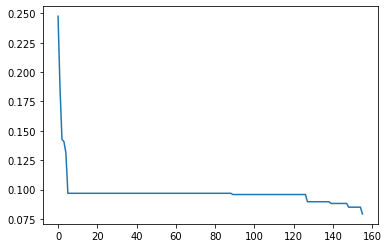

In [6]:
plt.plot(errors)

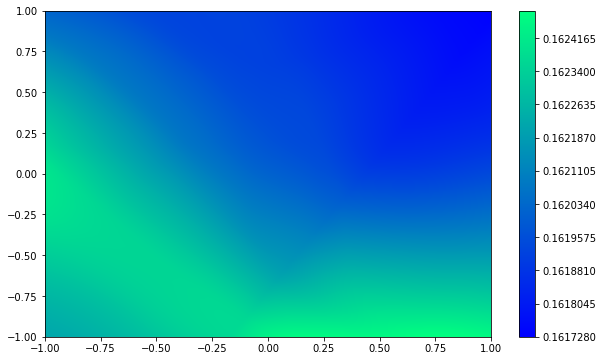

In [7]:
x_mesh = torch.linspace(down, up, 500, requires_grad=True)
mesh1, mesh2 = torch.meshgrid(x_mesh, x_mesh)
mesh_1 = torch.reshape(mesh1, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
mesh_2 = torch.reshape(mesh2, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
t = torch.linspace(0, 1, 11).unsqueeze(1).view(1, -1).repeat(250000, 1).unsqueeze(2).view(-1, 1, 11)
xt_comparison = torch.cat((mesh_1, mesh_2, t), dim=1)

u_net = generator(config)

error = torch.sqrt(torch.square(u_net(xt_comparison[:, 0, :], xt_comparison[:, 1, :], xt_comparison[:, 2, :]).squeeze(2)))
mean_error = torch.mean(error, dim=1)
mean_error = mean_error.view(500, 500)

plt.figure(figsize=(10,6))

cset=plt.contourf(mesh1.data.numpy(),mesh2.data.numpy(),mean_error.data.numpy(), 500, cmap='winter')

plt.colorbar(cset)
plt.show()

In [2]:
train(config)

Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


0 5.544768333435059 -4.681126594543457
error test 0.2977783977985382


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


10 5.787202835083008 -5.726252555847168
error test 0.15562500059604645


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


20 5.470956802368164 -5.449869155883789
error test 0.12678459286689758


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


30 5.334587574005127 -5.29904842376709
error test 0.09848231077194214


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


40 4.965542793273926 -4.915966987609863
error test 0.1412312388420105


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


50 5.121214389801025 -5.064761161804199
error test 0.12000814080238342


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


60 4.843169212341309 -4.810908317565918
error test 0.11752043664455414


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


70 4.984861850738525 -4.991900444030762
error test 0.1106012836098671


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


80 5.181425094604492 -5.180473327636719
error test 0.10657015442848206


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


90 4.993960380554199 -4.9054975509643555
error test 0.12508659064769745


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


100 5.13455867767334 -4.998117446899414
error test 0.10099427402019501


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


110 5.171247959136963 -5.14886474609375
error test 0.13020163774490356


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


120 5.009244441986084 -4.808759689331055
error test 0.10359606891870499


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


130 4.791156768798828 -4.490940093994141
error test 0.10811975598335266


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


140 4.859844207763672 -4.777387619018555
error test 0.08543416857719421


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


150 5.054337024688721 -4.970249176025391
error test 0.12581486999988556


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


160 5.1137776374816895 -4.891302108764648
error test 0.10411512106657028


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


170 3.884992837905884 -4.605140686035156
error test 0.0929301306605339


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


180 5.282785892486572 -5.05027961730957
error test 0.11058145016431808


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


190 4.897003173828125 -5.022361755371094
error test 0.10939732193946838


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


200 5.109497547149658 -5.18446159362793
error test 0.08788282424211502


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


210 4.379199504852295 -4.647966384887695
error test 0.11429896205663681


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


220 4.790950298309326 -4.598442077636719
error test 0.09990029036998749


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


230 4.103707313537598 -3.623811721801758
error test 0.09890782088041306


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


240 3.6694223880767822 -3.463644027709961
error test 0.10323020815849304


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


250 5.037391662597656 -4.66650390625
error test 0.09234706312417984


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


260 4.904694080352783 -4.412832260131836
error test 0.09348525106906891


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


270 5.258199691772461 -5.141481399536133
error test 0.10440032184123993


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


280 4.994792461395264 -4.903354644775391
error test 0.09946911036968231


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


290 5.0490875244140625 -4.73204231262207
error test 0.10055304318666458


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


300 5.644561767578125 -5.419767379760742
error test 0.11047250032424927


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


310 5.3952317237854 -5.762418746948242
error test 0.1266815960407257


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


320 4.832391262054443 -3.9419631958007812
error test 0.12849614024162292


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


330 5.373556613922119 -5.233999252319336
error test 0.12866346538066864


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


340 5.50239372253418 -5.433610916137695
error test 0.1172158494591713


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


350 5.345598220825195 -5.413656234741211
error test 0.10302963852882385


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


360 5.625519275665283 -5.493005752563477
error test 0.1202828660607338


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


370 5.390370845794678 -5.381900787353516
error test 0.12113267928361893


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


380 4.872659683227539 -5.457485198974609
error test 0.14777836203575134


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


390 5.2850022315979 -5.522867202758789
error test 0.10753470659255981


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


400 5.769077777862549 -5.201038360595703
error test 0.16062140464782715


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


410 5.482940196990967 -5.437326431274414
error test 0.12842105329036713


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


420 5.678455352783203 -5.721723556518555
error test 0.1336633265018463


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


430 5.745417594909668 -5.794013977050781
error test 0.14954844117164612


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


440 5.138019561767578 -4.128442764282227
error test 0.11995946615934372


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


450 5.389081001281738 -5.444416046142578
error test 0.15617771446704865


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


460 5.600305557250977 -5.457971572875977
error test 0.1663481593132019


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


470 6.084023952484131 -6.170083999633789
error test 0.16406932473182678


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


480 5.237414836883545 -5.237489700317383
error test 0.11211981624364853


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


490 5.810690879821777 -5.524284362792969
error test 0.1593286693096161


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


500 5.977101802825928 -5.853569030761719
error test 0.15596769750118256


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


510 5.398138999938965 -5.619691848754883
error test 0.13023753464221954


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


520 5.321723461151123 -5.14076042175293
error test 0.12436045706272125


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


530 5.480691909790039 -5.483449935913086
error test 0.12139572948217392


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


540 4.941012859344482 -5.0273284912109375
error test 0.12984882295131683


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


550 4.870169162750244 -4.8017120361328125
error test 0.126631960272789


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


560 5.271501064300537 -5.243419647216797
error test 0.13744840025901794


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


570 5.611929416656494 -5.732292175292969
error test 0.1479576975107193


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


580 5.279508113861084 -5.247919082641602
error test 0.12516112625598907


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


590 6.023621082305908 -5.822376251220703
error test 0.15914194285869598


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


600 5.411789417266846 -5.407356262207031
error test 0.13815359771251678


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


610 5.362557411193848 -5.322229385375977
error test 0.143448144197464


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


620 4.510370254516602 -4.937124252319336
error test 0.13058485090732574


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


630 5.321207046508789 -5.366111755371094
error test 0.14907091856002808


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


640 5.280367851257324 -5.237974166870117
error test 0.13634707033634186


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


650 5.0323615074157715 -5.164430618286133
error test 0.12157357484102249


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


660 5.1958327293396 -4.957923889160156
error test 0.15368618071079254


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


670 4.902826309204102 -4.864284515380859
error test 0.13443981111049652


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


680 5.138485431671143 -5.179254531860352
error test 0.1427994817495346


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


690 5.363461494445801 -5.147914886474609
error test 0.14199107885360718


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


700 5.370312213897705 -5.362739562988281
error test 0.13891366124153137


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


710 5.577294826507568 -5.617839813232422
error test 0.15416765213012695


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


720 4.813016414642334 -4.979696273803711
error test 0.12060540169477463


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


730 5.232479572296143 -5.431144714355469
error test 0.13378696143627167


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


740 5.568547248840332 -5.666345596313477
error test 0.11907973885536194


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


750 5.495938777923584 -5.257036209106445
error test 0.12913352251052856


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


760 5.421915054321289 -5.575387954711914
error test 0.14784537255764008


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


770 5.039431095123291 -5.16950798034668
error test 0.1350175142288208


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


780 5.298689365386963 -5.353328704833984
error test 0.14134620130062103


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


790 5.362499237060547 -5.087444305419922
error test 0.13049757480621338


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


800 5.70608377456665 -5.632204055786133
error test 0.15063056349754333


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


810 4.992839336395264 -4.920930862426758
error test 0.11951491236686707


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


820 5.264425754547119 -5.215450286865234
error test 0.12118008732795715


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


830 5.362911701202393 -5.2605438232421875
error test 0.1354382336139679


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


840 5.032301425933838 -5.192432403564453
error test 0.12239250540733337


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


850 4.976027011871338 -4.952657699584961
error test 0.1340292990207672


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


860 4.585091590881348 -3.9369277954101562
error test 0.11840762197971344


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


870 4.188178539276123 -4.7448883056640625
error test 0.10699193924665451


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


880 4.873261451721191 -5.035758972167969
error test 0.10530297458171844


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


890 4.488574028015137 -4.86445426940918
error test 0.11922641843557358


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


900 5.236448287963867 -5.172853469848633
error test 0.1309168040752411


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


910 5.412060737609863 -5.397960662841797
error test 0.11901556700468063


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


920 5.713565826416016 -5.59882926940918
error test 0.17517198622226715


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


930 4.660769462585449 -4.532100677490234
error test 0.11505722254514694


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


940 4.385010719299316 -4.238243103027344
error test 0.11004747450351715


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


950 5.000185966491699 -4.914279937744141
error test 0.09617029875516891


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


960 2.481449604034424 -4.368513107299805
error test 0.1197909265756607


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


970 5.307974338531494 -5.328563690185547
error test 0.12204571813344955


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


980 5.397486209869385 -5.364763259887695
error test 0.13389459252357483


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


990 5.294435977935791 -5.356174468994141
error test 0.1272655427455902


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1000 5.30314826965332 -4.805717468261719
error test 0.12711146473884583


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1010 4.985278606414795 -4.980573654174805
error test 0.1193094328045845


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1020 5.3254780769348145 -5.320478439331055
error test 0.1362990289926529


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1030 5.261188983917236 -5.384830474853516
error test 0.1283683329820633


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1040 5.284367561340332 -5.156900405883789
error test 0.13102823495864868


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1050 5.190707683563232 -5.179018020629883
error test 0.11961029469966888


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1060 5.078919887542725 -5.084053039550781
error test 0.11564736813306808


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1070 5.326321601867676 -5.356903076171875
error test 0.132551372051239


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1080 5.219061374664307 -5.165271759033203
error test 0.1284104287624359


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1090 5.153678894042969 -5.057575225830078
error test 0.11481538414955139


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1100 5.59322452545166 -5.564516067504883
error test 0.13046851754188538


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1110 5.667526721954346 -5.610633850097656
error test 0.13164401054382324


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1120 4.7030158042907715 -4.784427642822266
error test 0.12489890307188034


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1130 5.142604827880859 -5.158220291137695
error test 0.1248430609703064


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1140 5.5025200843811035 -5.576112747192383
error test 0.11552391946315765


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1150 4.8675689697265625 -4.769510269165039
error test 0.12117238342761993


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1160 5.433396339416504 -5.508983612060547
error test 0.12445461004972458


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1170 5.64409065246582 -5.674385070800781
error test 0.14029547572135925


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1180 5.0479559898376465 -5.053800582885742
error test 0.11979761719703674


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1190 5.385322093963623 -5.406068801879883
error test 0.12460789829492569


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1200 5.313129901885986 -5.195924758911133
error test 0.12042053788900375


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1210 5.273041248321533 -5.296478271484375
error test 0.12001027166843414


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1220 4.8591203689575195 -4.805505752563477
error test 0.12085093557834625


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1230 5.358611583709717 -5.333868026733398
error test 0.11993032693862915


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1240 5.0981011390686035 -5.046821594238281
error test 0.12913157045841217


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1250 5.740017414093018 -5.698873519897461
error test 0.15335743129253387


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1260 5.264670372009277 -5.180332183837891
error test 0.1329210251569748


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1270 5.6236042976379395 -5.519155502319336
error test 0.13510525226593018


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1280 5.712559700012207 -5.629619598388672
error test 0.15771828591823578


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1290 5.634725093841553 -5.591615676879883
error test 0.14020399749279022


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1300 5.522523403167725 -5.488986968994141
error test 0.15414202213287354


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1310 5.579071044921875 -5.055519104003906
error test 0.12348056584596634


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1320 5.1300787925720215 -5.189830780029297
error test 0.13849058747291565


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1330 5.687745571136475 -5.672328948974609
error test 0.13079026341438293


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1340 5.569685459136963 -5.520696640014648
error test 0.15493415296077728


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1350 5.594780445098877 -5.34172248840332
error test 0.1303408443927765


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1360 5.652459621429443 -5.7161407470703125
error test 0.1273660808801651


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1370 5.919619560241699 -5.873163223266602
error test 0.1250656545162201


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1380 5.4341607093811035 -5.474428176879883
error test 0.1270444691181183


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1390 4.736870288848877 -4.997953414916992
error test 0.1347215473651886


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1400 5.357310771942139 -5.463630676269531
error test 0.12989923357963562


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1410 5.4996657371521 -5.405401229858398
error test 0.12973088026046753


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1420 5.454521656036377 -5.418649673461914
error test 0.1225276067852974


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1430 4.754674434661865 -4.88385009765625
error test 0.12320280820131302


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1440 5.635209560394287 -5.495880126953125
error test 0.1319030225276947


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1450 5.271723747253418 -5.279191970825195
error test 0.11850502341985703


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1460 5.2961106300354 -5.320281982421875
error test 0.1362895965576172


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1470 5.324975967407227 -5.294893264770508
error test 0.13580258190631866


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1480 5.192675590515137 -5.188745498657227
error test 0.11711770296096802


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1490 5.291616439819336 -5.220830917358398
error test 0.13160614669322968


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1500 5.390141487121582 -5.314176559448242
error test 0.1294088214635849


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1510 5.419987201690674 -5.477838516235352
error test 0.1329309195280075


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1520 6.073268413543701 -5.935100555419922
error test 0.13329832255840302


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1530 5.544074058532715 -5.521379470825195
error test 0.11950625479221344


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1540 4.901662826538086 -4.780017852783203
error test 0.13128700852394104


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1550 5.322725772857666 -5.1868896484375
error test 0.14862708747386932


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1560 5.6844096183776855 -5.541265487670898
error test 0.15031762421131134


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1570 5.6857075691223145 -5.681669235229492
error test 0.1334935575723648


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1580 5.608067035675049 -5.540927886962891
error test 0.1424218714237213


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1590 5.638962268829346 -5.450986862182617
error test 0.1300266683101654


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1600 5.566280841827393 -5.42350959777832
error test 0.12387265264987946


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1610 4.945067405700684 -5.066751480102539
error test 0.14049823582172394


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1620 4.552028179168701 -4.664455413818359
error test 0.124751016497612


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1630 4.884920597076416 -4.899923324584961
error test 0.11458161473274231


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1640 5.307317733764648 -5.305278778076172
error test 0.14112567901611328


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1650 5.177876949310303 -5.207012176513672
error test 0.13427303731441498


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1660 5.506150722503662 -5.329158782958984
error test 0.130366250872612


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1670 5.318095684051514 -5.301155090332031
error test 0.12416764348745346


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1680 4.047647476196289 -4.88218879699707
error test 0.13630618155002594


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1690 5.5063581466674805 -5.463476181030273
error test 0.1282806545495987


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1700 5.686812400817871 -5.58660888671875
error test 0.11692353338003159


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1710 5.787021160125732 -5.868778228759766
error test 0.1434476226568222


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1720 5.56883430480957 -5.415348052978516
error test 0.14437346160411835


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1730 5.158038139343262 -5.161569595336914
error test 0.12805458903312683


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1740 5.525963306427002 -5.567081451416016
error test 0.12955808639526367


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1750 5.825405120849609 -5.811100006103516
error test 0.1263028234243393


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1760 3.95239520072937 -4.083478927612305
error test 0.12490593641996384


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1770 5.146195888519287 -4.8929443359375
error test 0.12400292605161667


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1780 5.680695533752441 -5.402107238769531
error test 0.14940576255321503


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1790 5.21766996383667 -5.306232452392578
error test 0.13675318658351898


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1800 1.7814322710037231 -2.002521514892578
error test 0.12146425992250443


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1810 5.553236484527588 -5.57989501953125
error test 0.12474233657121658


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1820 4.516668796539307 -4.417041778564453
error test 0.1324155032634735


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1830 3.967308759689331 -4.358512878417969
error test 0.13891705870628357


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1840 5.074868679046631 -5.020822525024414
error test 0.1153419241309166


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1850 3.970456123352051 -4.34147834777832
error test 0.11151047050952911


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1860 5.215998649597168 -4.750688552856445
error test 0.1264980137348175


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1870 5.716250896453857 -5.577028274536133
error test 0.14599746465682983


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1880 5.139543533325195 -4.9377593994140625
error test 0.12117524445056915


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1890 3.833465576171875 -3.8550853729248047
error test 0.12752467393875122


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1900 5.227998733520508 -5.2148895263671875
error test 0.13400569558143616


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1910 4.825066089630127 -4.6307373046875
error test 0.121792733669281


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1920 3.893991470336914 -4.602540969848633
error test 0.12644830346107483


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1930 5.334181308746338 -5.479616165161133
error test 0.1277371495962143


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1940 5.19636344909668 -5.415655136108398
error test 0.1393641233444214


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1950 5.326216697692871 -5.35453987121582
error test 0.13154903054237366


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1960 5.120026111602783 -5.1265411376953125
error test 0.12602652609348297


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1970 5.534137725830078 -5.412006378173828
error test 0.1366800218820572


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1980 5.044848918914795 -5.4452362060546875
error test 0.1032593846321106


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


1990 4.876376152038574 -4.803750991821289
error test 0.1095314472913742


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2000 5.830124378204346 -5.819459915161133
error test 0.11165420711040497


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2010 4.817307472229004 -4.482755661010742
error test 0.11245974898338318


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2020 5.365078449249268 -5.375995635986328
error test 0.11778214573860168


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2030 4.089035987854004 -4.157386779785156
error test 0.10823091864585876


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2040 5.301795959472656 -5.253452301025391
error test 0.11217140406370163


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2050 0.17375217378139496 -3.0585975646972656
error test 0.10063967853784561


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2060 4.465889930725098 -3.75799560546875
error test 0.14022810757160187


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2070 5.543589115142822 -5.482156753540039
error test 0.11675678938627243


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2080 2.9867303371429443 -3.781984329223633
error test 0.12109046429395676


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2090 0.2796920835971832 -1.1398124694824219
error test 0.11383511126041412


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2100 5.703754425048828 -5.773601531982422
error test 0.12976165115833282


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2110 7.290233135223389 -6.917642593383789
error test 0.142816960811615


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2120 5.404141902923584 -5.0598907470703125
error test 0.10780713707208633


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2130 5.2848615646362305 -5.401674270629883
error test 0.1282867044210434


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2140 5.89999532699585 -5.706521987915039
error test 0.11484205722808838


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2150 5.819881916046143 -5.734025955200195
error test 0.1261313259601593


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2160 5.4863481521606445 -5.490968704223633
error test 0.10902108252048492


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2170 5.266993999481201 -5.621341705322266
error test 0.10988729447126389


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2180 4.767577171325684 -5.2274932861328125
error test 0.12364201247692108


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2190 5.273437976837158 -5.322032928466797
error test 0.10836203396320343


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2200 2.327625036239624 -1.253744125366211
error test 0.12189392745494843


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2210 5.311341285705566 -5.348499298095703
error test 0.12160585075616837


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2220 4.535811901092529 -4.795967102050781
error test 0.12343694269657135


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2230 4.109546184539795 -5.018001556396484
error test 0.1131366491317749


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2240 -0.032250963151454926 -1.061208724975586
error test 0.10197436064481735


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2250 6.725680828094482 -6.519979476928711
error test 0.12668344378471375


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2260 6.235045433044434 -6.130786895751953
error test 0.1256411373615265


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2270 3.3664088249206543 -3.906156539916992
error test 0.13017624616622925


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2280 -0.6326690912246704 -6.184444427490234
error test 0.11479600518941879


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2290 4.4235429763793945 -4.602764129638672
error test 0.11348450183868408


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2300 3.569481372833252 -5.00324821472168
error test 0.09712497889995575


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2310 4.887157917022705 -5.15770149230957
error test 0.1089111939072609


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2320 4.613710880279541 -4.179931640625
error test 0.10356203466653824


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2330 3.373652219772339 -3.4022045135498047
error test 0.09704658389091492


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2340 3.754399061203003 -4.437145233154297
error test 0.09968966990709305


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2350 4.577766418457031 -4.6093292236328125
error test 0.10438072681427002


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2360 3.7951114177703857 -5.231605529785156
error test 0.10973577201366425


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2370 5.473540306091309 -4.883029937744141
error test 0.11275327950716019


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2380 4.711181163787842 -4.331216812133789
error test 0.09939408302307129


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2390 4.732484817504883 -4.555973052978516
error test 0.090451680123806


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2400 5.177884101867676 -5.309488296508789
error test 0.08806004375219345


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2410 5.393078804016113 -5.300518035888672
error test 0.10102645307779312


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2420 5.077565670013428 -5.40257453918457
error test 0.10202204436063766


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2430 5.599738597869873 -5.611263275146484
error test 0.1168288066983223


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2440 5.0973968505859375 -4.931243896484375
error test 0.11047130823135376


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2450 4.332407474517822 -4.342220306396484
error test 0.10758093744516373


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2460 4.705745220184326 -5.434419631958008
error test 0.11753924936056137


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2470 4.450461387634277 -3.766012191772461
error test 0.10934000462293625


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2480 5.6088457107543945 -5.643608093261719
error test 0.10365966707468033


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2490 4.632416248321533 -4.51048469543457
error test 0.08921907842159271


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2500 4.806938648223877 -5.158222198486328
error test 0.11049864441156387


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2510 4.616814136505127 -4.604686737060547
error test 0.10289732366800308


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2520 4.914865970611572 -4.815219879150391
error test 0.09987950325012207


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2530 4.319066524505615 -5.080453872680664
error test 0.10631620138883591


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2540 5.461691856384277 -5.161893844604492
error test 0.10933756828308105


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2550 5.026253700256348 -5.01197624206543
error test 0.09898499399423599


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2560 3.5041253566741943 -3.0240478515625
error test 0.104398213326931


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2570 5.357578754425049 -5.225568771362305
error test 0.10625219345092773


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2580 5.181358814239502 -5.235544204711914
error test 0.10739235579967499


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2590 4.926438808441162 -4.47943115234375
error test 0.09654052555561066


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2600 6.021368026733398 -5.9747314453125
error test 0.1277252435684204


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2610 5.058095455169678 -4.7043304443359375
error test 0.10549113154411316


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2620 4.35684871673584 -4.218112945556641
error test 0.10600004345178604


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2630 4.990451812744141 -5.93104362487793
error test 0.12428677082061768


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2640 5.376294136047363 -5.320219039916992
error test 0.10139159858226776


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2650 5.316627502441406 -5.210367202758789
error test 0.1214650496840477


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2660 5.893750190734863 -5.984607696533203
error test 0.11551462113857269


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2670 4.72750997543335 -4.963775634765625
error test 0.11440077424049377


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2680 4.372679233551025 -4.2625274658203125
error test 0.09774087369441986


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2690 4.614044189453125 -4.454936981201172
error test 0.12180449813604355


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2700 5.2152485847473145 -5.109121322631836
error test 0.11349213868379593


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2710 5.677052974700928 -5.103784561157227
error test 0.10591330379247665


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2720 5.281268119812012 -5.533763885498047
error test 0.10732103139162064


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2730 4.916093826293945 -5.0727386474609375
error test 0.1254362314939499


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2740 4.642265319824219 -4.966217041015625
error test 0.12586863338947296


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2750 5.485284805297852 -5.0334014892578125
error test 0.11023300886154175


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2760 5.266972064971924 -4.993598937988281
error test 0.12237155437469482


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2770 5.705381393432617 -5.453569412231445
error test 0.10954969376325607


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2780 5.094245910644531 -5.220573425292969
error test 0.09470987319946289


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2790 5.254312038421631 -4.86640739440918
error test 0.10100255161523819


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2800 4.789615154266357 -4.305723190307617
error test 0.09969426691532135


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2810 4.238860130310059 -4.019256591796875
error test 0.08292921632528305


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2820 5.809750080108643 -5.763690948486328
error test 0.13296939432621002


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2830 4.838400840759277 -4.52393913269043
error test 0.08917239308357239


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2840 5.4521613121032715 -5.735174179077148
error test 0.08891936391592026


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2850 5.137049674987793 -5.330852508544922
error test 0.09670325368642807


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2860 4.818441390991211 -3.911649703979492
error test 0.1252271980047226


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2870 4.061187744140625 -4.116376876831055
error test 0.08674043416976929


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2880 4.829293251037598 -5.056133270263672
error test 0.09276409447193146


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2890 -0.4270459711551666 0.8967552185058594
error test 0.0973971039056778


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2900 5.358328819274902 -5.396978378295898
error test 0.10329363495111465


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2910 4.525224685668945 -4.697120666503906
error test 0.08262892812490463


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2920 4.793187141418457 -3.9858551025390625
error test 0.09642264991998672


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2930 5.288785457611084 -5.323566436767578
error test 0.07642997801303864


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2940 5.706207275390625 -5.425868988037109
error test 0.09780603647232056


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2950 5.05607795715332 -4.8351287841796875
error test 0.11148536950349808


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2960 4.66149377822876 -4.906667709350586
error test 0.09094759821891785


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2970 3.9802157878875732 -4.368135452270508
error test 0.08995448797941208


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2980 4.448347091674805 -4.719335556030273
error test 0.08783218264579773


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


2990 4.028101921081543 -3.800626754760742
error test 0.09865711629390717


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3000 4.21309232711792 -4.368066787719727
error test 0.07822945713996887


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3010 4.858460903167725 -4.5400238037109375
error test 0.08898118883371353


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3020 4.17474365234375 -4.262807846069336
error test 0.09717967361211777


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3030 4.582810878753662 -4.38273811340332
error test 0.10026171803474426


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3040 4.73915958404541 -4.283451080322266
error test 0.09515125304460526


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3050 4.896056652069092 -4.860509872436523
error test 0.10194959491491318


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3060 4.6491241455078125 -4.662534713745117
error test 0.0915193036198616


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3070 1.2126967906951904 -2.409391403198242
error test 0.10095985978841782


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3080 4.061555862426758 -4.370298385620117
error test 0.08912680298089981


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3090 4.252963542938232 -4.133480072021484
error test 0.0965527892112732


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3100 4.3310933113098145 -3.9981460571289062
error test 0.09745344519615173


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3110 4.85696268081665 -4.874425888061523
error test 0.09612874686717987


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3120 2.6338417530059814 -2.7432308197021484
error test 0.09813109040260315


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3130 3.5700902938842773 -3.5821685791015625
error test 0.10192488878965378


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3140 3.0029454231262207 -3.1380672454833984
error test 0.08588340878486633


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3150 3.802715301513672 -3.850553512573242
error test 0.0805002972483635


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3160 3.709305763244629 -3.447610855102539
error test 0.07744979113340378


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3170 4.071951389312744 -4.104335784912109
error test 0.0924028605222702


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3180 2.741663694381714 -2.6464271545410156
error test 0.08948874473571777


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3190 3.798274040222168 -3.975574493408203
error test 0.08492016047239304


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3200 3.7493667602539062 -3.8006153106689453
error test 0.0819055363535881


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3210 3.3560333251953125 -3.656055450439453
error test 0.08239548653364182


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3220 2.877204656600952 -3.623075485229492
error test 0.1014256700873375


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3230 2.3183367252349854 -2.338348388671875
error test 0.08340208977460861


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3240 3.481328248977661 -3.410907745361328
error test 0.09563352912664413


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3250 4.226617336273193 -4.12054443359375
error test 0.08393588662147522


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3260 3.656574249267578 -3.9562416076660156
error test 0.09336747229099274


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3270 3.601344108581543 -3.6883888244628906
error test 0.08760501444339752


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3280 2.617860794067383 -3.8728370666503906
error test 0.08327434957027435


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3290 2.7790842056274414 -2.9154052734375
error test 0.08770711719989777


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3300 3.4957144260406494 -2.4471492767333984
error test 0.09918193519115448


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3310 3.8976900577545166 -3.8302745819091797
error test 0.08424320816993713


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3320 4.596038818359375 -4.532928466796875
error test 0.08456645905971527


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3330 3.6130599975585938 -4.005542755126953
error test 0.09194187819957733


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3340 2.4222724437713623 -2.0304527282714844
error test 0.07869488000869751


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3350 3.852130174636841 -3.375406265258789
error test 0.08842303603887558


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3360 3.7714622020721436 -4.320323944091797
error test 0.11463266611099243


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3370 4.294829368591309 -3.985288619995117
error test 0.10454387962818146


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3380 4.157871246337891 -4.274614334106445
error test 0.10207602381706238


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3390 3.5657618045806885 -3.767505645751953
error test 0.08846971392631531


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3400 4.099370956420898 -4.217409133911133
error test 0.09228815883398056


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3410 3.0820209980010986 -3.5609569549560547
error test 0.0888654962182045


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3420 4.28634786605835 -4.203283309936523
error test 0.10731565952301025


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3430 3.4523098468780518 -3.2261791229248047
error test 0.09082377701997757


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3440 3.4287049770355225 -3.5725460052490234
error test 0.10006177425384521


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3450 3.7855474948883057 -3.286958694458008
error test 0.09479338675737381


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3460 2.5787363052368164 -2.8507614135742188
error test 0.0867885872721672


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3470 2.0184755325317383 -0.08571243286132812
error test 0.08947981894016266


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3480 3.6124234199523926 -4.04389762878418
error test 0.10918369889259338


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3490 3.8275222778320312 -3.549795150756836
error test 0.09748870134353638


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3500 2.2692959308624268 -1.890493392944336
error test 0.09227055311203003


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3510 4.389403820037842 -4.837799072265625
error test 0.11808104813098907


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3520 3.2273025512695312 -2.4894046783447266
error test 0.09718242287635803


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3530 5.596867561340332 -3.613250732421875
error test 0.09328027069568634


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3540 3.241762161254883 0.4823284149169922
error test 0.09504605084657669


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3550 5.122304439544678 -3.7888126373291016
error test 0.1308557093143463


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3560 0.42369452118873596 -1.4940242767333984
error test 0.10465525835752487


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3570 3.5988612174987793 -3.852886199951172
error test 0.10401729494333267


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3580 2.7945308685302734 -3.096719741821289
error test 0.10721669346094131


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3590 0.37405139207839966 0.6077938079833984
error test 0.11174866557121277


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3600 2.8444223403930664 -2.211048126220703
error test 0.09821785986423492


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3610 2.898569345474243 -2.6489028930664062
error test 0.10886374115943909


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3620 4.037265300750732 -1.3264999389648438
error test 0.10963020473718643


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3630 3.9211950302124023 -3.6850948333740234
error test 0.104328952729702


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3640 3.7590744495391846 -3.580963134765625
error test 0.09384352713823318


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3650 4.465869426727295 -4.486360549926758
error test 0.09548191726207733


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3660 0.9090362191200256 -2.6101608276367188
error test 0.09119828790426254


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3670 1.5889475345611572 -2.6335678100585938
error test 0.09167446941137314


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3680 4.322019100189209 -3.1165847778320312
error test 0.10669142752885818


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3690 0.6530228853225708 -0.7463760375976562
error test 0.09406688064336777


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3700 2.9494998455047607 -2.8899269104003906
error test 0.09514790028333664


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3710 -6.708446979522705 -1.3100852966308594
error test 0.09202022850513458


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3720 3.475048065185547 -4.500545501708984
error test 0.11496055871248245


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3730 3.11018967628479 -2.8631420135498047
error test 0.08970873802900314


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3740 0.4450776278972626 -2.1802215576171875
error test 0.10203373432159424


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3750 -1.5240777730941772 -1.4420032501220703
error test 0.09324294328689575


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3760 -4.563868045806885 -1.153289794921875
error test 0.10274505615234375


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3770 3.8725531101226807 -4.11895751953125
error test 0.09994872659444809


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3780 3.6256263256073 -3.673177719116211
error test 0.11263962090015411


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3790 -4.057401180267334 -0.5741958618164062
error test 0.09082524478435516


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3800 1.0674530267715454 -3.2305545806884766
error test 0.11602240055799484


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3810 2.7116527557373047 -3.088846206665039
error test 0.10313328355550766


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3820 0.152300626039505 -1.5651493072509766
error test 0.10947016626596451


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3830 1.6627427339553833 -1.6887760162353516
error test 0.11449884623289108


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3840 4.170005798339844 -2.697521209716797
error test 0.10471397638320923


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3850 0.40071651339530945 -3.6347618103027344
error test 0.10937417298555374


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3860 1.2399070262908936 -1.5759334564208984
error test 0.10520052909851074


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3870 -0.576806366443634 -1.1089916229248047
error test 0.12819735705852509


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3880 -0.381674587726593 -1.6590576171875
error test 0.11014135181903839


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3890 4.077503681182861 -4.4557037353515625
error test 0.10558690130710602


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3900 3.2846479415893555 -5.259860992431641
error test 0.10392298549413681


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3910 4.630977153778076 -2.0614051818847656
error test 0.10605158656835556


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3920 4.153719425201416 -3.815610885620117
error test 0.11303260177373886


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3930 4.680964946746826 -4.528039932250977
error test 0.11819372326135635


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3940 4.943404674530029 -4.842931747436523
error test 0.11316812038421631


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3950 4.776998519897461 -4.547706604003906
error test 0.09575534611940384


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3960 4.115355968475342 -2.908740997314453
error test 0.09533306211233139


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3970 5.201748847961426 -5.227937698364258
error test 0.1137828677892685


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3980 4.117185115814209 -5.000528335571289
error test 0.0945843830704689


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


3990 4.407676696777344 -4.961383819580078
error test 0.10802078992128372


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4000 4.478034019470215 -4.357645034790039
error test 0.08971564471721649


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4010 4.657220363616943 -4.395040512084961
error test 0.09320587664842606


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4020 4.929468631744385 -4.533069610595703
error test 0.08887095004320145


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4030 5.324923515319824 -5.60767936706543
error test 0.11444465816020966


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4040 4.852494239807129 -4.697786331176758
error test 0.1164565160870552


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4050 4.73328161239624 -4.569646835327148
error test 0.11610636115074158


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4060 4.642480373382568 -4.31062126159668
error test 0.09470269083976746


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4070 5.070222854614258 -5.088891983032227
error test 0.10082896798849106


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4080 4.633454322814941 -4.322795867919922
error test 0.1017671748995781


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4090 4.683873653411865 -4.334543228149414
error test 0.09903392195701599


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4100 5.100428104400635 -4.977659225463867
error test 0.09609070420265198


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4110 4.698418617248535 -4.827058792114258
error test 0.09909076988697052


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4120 4.685089588165283 -4.697492599487305
error test 0.11207898706197739


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4130 5.038877010345459 -5.443473815917969
error test 0.10116570442914963


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4140 4.874385833740234 -4.914035797119141
error test 0.10625268518924713


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4150 4.8764238357543945 -5.076139450073242
error test 0.09936023503541946


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4160 5.485596179962158 -4.80164909362793
error test 0.0901603251695633


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4170 0.7856500744819641 -1.059030532836914
error test 0.09838278591632843


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4180 4.0924506187438965 -4.704462051391602
error test 0.0976051464676857


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4190 3.9573047161102295 -3.5510425567626953
error test 0.1085631400346756


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4200 2.4332172870635986 -3.770069122314453
error test 0.10859431326389313


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4210 4.649052143096924 -4.106929779052734
error test 0.097598597407341


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4220 4.8614726066589355 -4.81048583984375
error test 0.09464923292398453


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4230 4.594051361083984 -4.618207931518555
error test 0.0870007798075676


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4240 4.900903224945068 -4.346841812133789
error test 0.09440343081951141


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4250 4.463129043579102 -4.010791778564453
error test 0.0955793634057045


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4260 4.251890182495117 -4.588165283203125
error test 0.10929499566555023


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4270 4.542257785797119 -3.8330039978027344
error test 0.08683127164840698


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4280 3.2388250827789307 -2.980316162109375
error test 0.09213487058877945


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4290 5.732118606567383 -5.119358062744141
error test 0.10683268308639526


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4300 4.055835247039795 -3.8493995666503906
error test 0.09657908976078033


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4310 3.239722490310669 -4.728517532348633
error test 0.09779997915029526


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4320 6.1827287673950195 -6.698102951049805
error test 0.1169319823384285


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4330 4.083695411682129 -4.529848098754883
error test 0.08993113785982132


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4340 3.5457139015197754 -3.9116687774658203
error test 0.10086388140916824


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4350 4.912359237670898 -4.307952880859375
error test 0.08985656499862671


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4360 2.863978862762451 -4.135066986083984
error test 0.08315510302782059


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4370 5.151187419891357 -5.361198425292969
error test 0.0983060821890831


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4380 3.5384585857391357 -0.21261024475097656
error test 0.09502770006656647


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4390 5.709678649902344 -1.936960220336914
error test 0.1002751886844635


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4400 4.8728766441345215 -4.401012420654297
error test 0.11154232174158096


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4410 4.462268352508545 -2.4250965118408203
error test 0.10713093727827072


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4420 3.7023489475250244 -4.379253387451172
error test 0.09831038862466812


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4430 3.894540548324585 -3.4973278045654297
error test 0.09992977231740952


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4440 4.470792293548584 -4.580478668212891
error test 0.09034278988838196


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4450 4.9831414222717285 -4.798135757446289
error test 0.09495723992586136


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4460 5.0403828620910645 -4.986530303955078
error test 0.10865271836519241


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4470 3.9275405406951904 -4.379644393920898
error test 0.089129738509655


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4480 5.084771156311035 -5.142704010009766
error test 0.11060800403356552


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4490 4.959192276000977 -4.6680908203125
error test 0.08814126998186111


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4500 4.770529270172119 -4.036357879638672
error test 0.08779136091470718


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4510 4.84834623336792 -5.077226638793945
error test 0.08887923508882523


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4520 4.777547836303711 -4.397989273071289
error test 0.08138670772314072


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4530 4.273461818695068 -4.042488098144531
error test 0.09243065118789673


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4540 4.436343193054199 -4.821968078613281
error test 0.09089366346597672


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4550 4.328094005584717 -3.8006858825683594
error test 0.0835808664560318


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4560 1.408225178718567 -1.0019264221191406
error test 0.08720795810222626


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4570 1.3786262273788452 -1.2214183807373047
error test 0.10582984238862991


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4580 4.699806213378906 -4.742650985717773
error test 0.08607452362775803


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4590 4.735029697418213 -4.802236557006836
error test 0.08489036560058594


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4600 4.5498762130737305 -3.6563072204589844
error test 0.155557319521904


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4610 5.127171993255615 -5.04490852355957
error test 0.11039731651544571


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4620 4.266439914703369 -4.55082893371582
error test 0.10165437310934067


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4630 5.09432315826416 -4.988683700561523
error test 0.09498297423124313


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4640 3.3911001682281494 3.0670604705810547
error test 0.11635835468769073


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4650 3.3190460205078125 -1.762277603149414
error test 0.11989586055278778


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4660 4.883673191070557 -4.759679794311523
error test 0.1112971156835556


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4670 4.5685200691223145 -4.678644180297852
error test 0.11258349567651749


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4680 4.9266228675842285 -4.864830017089844
error test 0.0933663621544838


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4690 4.941343307495117 -4.913028717041016
error test 0.09280775487422943


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4700 5.025228023529053 -5.123638153076172
error test 0.0996917113661766


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4710 4.899063587188721 -5.0483245849609375
error test 0.10892830789089203


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4720 5.046800136566162 -5.144876480102539
error test 0.0913318395614624


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4730 5.154994010925293 -5.603824615478516
error test 0.10952602326869965


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4740 3.271796703338623 -3.543426513671875
error test 0.09627949446439743


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4750 5.2682976722717285 -5.023445129394531
error test 0.09288675338029861


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4760 3.845317840576172 -4.718788146972656
error test 0.12038730084896088


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4770 4.966150760650635 -5.351264953613281
error test 0.093714639544487


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4780 5.076485633850098 -5.041038513183594
error test 0.10543521493673325


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4790 4.728841781616211 -3.0614547729492188
error test 0.09391328692436218


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4800 5.464402198791504 -1.0885181427001953
error test 0.10710486769676208


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4810 3.4752590656280518 -4.581480026245117
error test 0.09619107097387314


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4820 3.5930824279785156 -4.249517440795898
error test 0.11022582650184631


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4830 5.413947582244873 -4.764438629150391
error test 0.12611040472984314


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4840 5.281118392944336 -5.307376861572266
error test 0.12390404939651489


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4850 4.851130962371826 -4.849739074707031
error test 0.12135275453329086


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4860 5.504482269287109 -5.489009857177734
error test 0.1453428417444229


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4870 4.966639041900635 -5.436283111572266
error test 0.1027606874704361


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4880 5.096606254577637 -5.085077285766602
error test 0.0964926928281784


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4890 4.8002214431762695 -4.008411407470703
error test 0.09482642263174057


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4900 5.6980791091918945 -5.6275634765625
error test 0.1383514702320099


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4910 5.441979885101318 -5.457231521606445
error test 0.12609176337718964


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4920 3.5854194164276123 -3.351499557495117
error test 0.12671105563640594


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4930 5.0018696784973145 -5.155649185180664
error test 0.09396108984947205


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4940 5.464987754821777 -4.874607086181641
error test 0.12391895055770874


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4950 4.989539623260498 -4.927333831787109
error test 0.09993210434913635


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4960 5.368320941925049 -5.270805358886719
error test 0.10032510757446289


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4970 3.6401946544647217 -5.137102127075195
error test 0.08921808004379272


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4980 4.62595272064209 -4.695224761962891
error test 0.11441127210855484


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


4990 5.486353397369385 -5.231636047363281
error test 0.09697922319173813


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5000 3.8737878799438477 -4.559406280517578
error test 0.08748868107795715


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5010 4.452943801879883 -4.713371276855469
error test 0.07872937619686127


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5020 4.343041896820068 -4.1116180419921875
error test 0.11254311352968216


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5030 5.174322605133057 -5.243936538696289
error test 0.09279369562864304


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5040 5.42489767074585 -5.273124694824219
error test 0.08713001012802124


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5050 5.17504358291626 -5.13926887512207
error test 0.09431884437799454


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5060 5.693016529083252 -5.55836296081543
error test 0.08733107149600983


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5070 5.0365095138549805 -5.450313568115234
error test 0.07777602970600128


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5080 5.328580856323242 -5.205402374267578
error test 0.14195194840431213


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5090 5.667739391326904 -4.40040397644043
error test 0.09739316254854202


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5100 5.265788555145264 -4.880205154418945
error test 0.0845312625169754


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5110 5.061668872833252 -3.378671646118164
error test 0.08348403126001358


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5120 5.150091171264648 -4.6915130615234375
error test 0.07902999222278595


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5130 6.314549446105957 -6.0008544921875
error test 0.11189360916614532


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5140 5.112449645996094 -5.24737548828125
error test 0.11703430116176605


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5150 4.100925922393799 -4.529375076293945
error test 0.08030035346746445


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5160 4.82924747467041 -5.339717864990234
error test 0.10148854553699493


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5170 4.062459468841553 -5.083881378173828
error test 0.08202117681503296


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5180 4.839667320251465 -4.704319000244141
error test 0.09282959997653961


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5190 4.99496603012085 -4.7970733642578125
error test 0.07994668930768967


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5200 6.195995807647705 -3.4123306274414062
error test 0.07781042158603668


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5210 3.9771840572357178 -3.45880126953125
error test 0.07192493975162506


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5220 5.268725872039795 -4.948843002319336
error test 0.09372089803218842


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5230 4.970045566558838 -5.136665344238281
error test 0.08611667156219482


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5240 5.236064910888672 -5.358678817749023
error test 0.10776854306459427


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5250 4.7827324867248535 -4.996116638183594
error test 0.07719126343727112


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5260 5.605930805206299 -4.635759353637695
error test 0.08360433578491211


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5270 4.164755821228027 -4.427221298217773
error test 0.08052900433540344


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5280 5.33986759185791 -5.218475341796875
error test 0.10871241986751556


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5290 4.770406723022461 -4.059169769287109
error test 0.11553838104009628


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5300 5.004140853881836 -5.230276107788086
error test 0.09921188652515411


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5310 3.820824146270752 -3.4393482208251953
error test 0.1079871878027916


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5320 5.004002571105957 -4.6674652099609375
error test 0.07976808398962021


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5330 2.3570923805236816 -4.979635238647461
error test 0.08222562074661255


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5340 4.624734878540039 -4.899820327758789
error test 0.08233551681041718


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5350 4.562908172607422 -4.095409393310547
error test 0.08830831944942474


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5360 3.413792133331299 -3.2612648010253906
error test 0.09494831413030624


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5370 4.52408504486084 -4.177616119384766
error test 0.10906760394573212


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5380 5.055980682373047 -4.9289093017578125
error test 0.08327050507068634


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5390 4.666402339935303 -3.243612289428711
error test 0.08533042669296265


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5400 -0.6698250770568848 -4.098030090332031
error test 0.08685535192489624


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5410 3.3788630962371826 -3.5951881408691406
error test 0.08552774041891098


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5420 9.107697486877441 -6.619873046875
error test 0.08616343140602112


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5430 6.599729061126709 -6.5240325927734375
error test 0.09860660880804062


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5440 2.5464096069335938 -2.6599960327148438
error test 0.10092725604772568


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5450 0.05378236621618271 -2.311891555786133
error test 0.09539730101823807


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5460 6.369449615478516 -5.406314849853516
error test 0.09490769356489182


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5470 4.573430061340332 -4.307216644287109
error test 0.10469064861536026


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5480 4.557753562927246 -4.958976745605469
error test 0.07379049062728882


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5490 5.553584098815918 -5.789468765258789
error test 0.09412986040115356


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5500 4.5483598709106445 -4.327993392944336
error test 0.07402132451534271


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5510 1.6819312572479248 -3.1269149780273438
error test 0.08267416059970856


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5520 4.032668590545654 -5.009462356567383
error test 0.06826245039701462


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5530 4.27638578414917 -3.9214859008789062
error test 0.10856469720602036


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5540 5.27900505065918 -2.8708362579345703
error test 0.06430628150701523


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5550 5.260297775268555 -3.5556411743164062
error test 0.1398303359746933


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5560 4.7483954429626465 -4.721151351928711
error test 0.10685986280441284


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5570 4.991345405578613 -5.247219085693359
error test 0.08452712744474411


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5580 4.728808879852295 -4.197057723999023
error test 0.05814393237233162


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5590 6.074066638946533 -4.496696472167969
error test 0.08436503261327744


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5600 4.627309322357178 -4.722911834716797
error test 0.09221814572811127


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5610 4.472939491271973 -7.713911056518555
error test 0.11325383931398392


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5620 5.3356547355651855 -5.071441650390625
error test 0.08455560356378555


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5630 3.6821014881134033 -2.5354747772216797
error test 0.0794556513428688


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5640 4.2833333015441895 -4.176658630371094
error test 0.08847711235284805


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5650 4.549157619476318 -3.375274658203125
error test 0.07662209123373032


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5660 5.497673511505127 -5.378927230834961
error test 0.1221984401345253


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5670 5.10330057144165 -5.368648529052734
error test 0.06892120838165283


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5680 5.114112854003906 -4.689929962158203
error test 0.09660378843545914


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5690 4.627908706665039 -5.156045913696289
error test 0.08061885833740234


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5700 5.245777606964111 -5.080568313598633
error test 0.11020921170711517


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5710 4.975589752197266 -5.05876350402832
error test 0.11662118136882782


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5720 4.9545512199401855 -4.900211334228516
error test 0.10271918028593063


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5730 5.191633224487305 -4.16111946105957
error test 0.11711374670267105


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5740 4.438579082489014 -4.857988357543945
error test 0.08043859899044037


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5750 4.745731830596924 -4.728691101074219
error test 0.09714832156896591


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5760 4.159379959106445 -4.547626495361328
error test 0.06806065887212753


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5770 5.2551045417785645 -5.642160415649414
error test 0.11769081652164459


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5780 5.345626354217529 -4.000324249267578
error test 0.07661916315555573


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5790 4.635474681854248 -4.904762268066406
error test 0.06925350427627563


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5800 4.312021732330322 -3.629209518432617
error test 0.09944318234920502


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5810 2.1782493591308594 -3.3269119262695312
error test 0.07291129976511002


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5820 3.190086603164673 -2.9408397674560547
error test 0.08499626070261002


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5830 5.0673747062683105 -5.004547119140625
error test 0.08564488589763641


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5840 5.161190986633301 -4.944904327392578
error test 0.09791094064712524


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5850 6.295864105224609 -6.343847274780273
error test 0.0795019119977951


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5860 4.944548606872559 -4.9960479736328125
error test 0.08144053816795349


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5870 5.568304061889648 -5.1936798095703125
error test 0.10209216177463531


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5880 5.206917762756348 -5.243307113647461
error test 0.11370550841093063


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5890 5.343854904174805 -5.373836517333984
error test 0.10665791481733322


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5900 4.758755207061768 -4.880046844482422
error test 0.0967579185962677


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5910 4.749913692474365 -4.64436149597168
error test 0.10028679668903351


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5920 3.9102401733398438 0.3648643493652344
error test 0.07791881263256073


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5930 4.947352886199951 -4.86048698425293
error test 0.11437299847602844


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5940 4.058549404144287 -4.197334289550781
error test 0.10275585949420929


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5950 5.201157093048096 -5.073528289794922
error test 0.08976719528436661


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5960 2.996912956237793 -1.1555614471435547
error test 0.07887933403253555


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5970 5.2449541091918945 -5.196109771728516
error test 0.10136599838733673


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5980 5.062562465667725 -4.422601699829102
error test 0.06561926007270813


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


5990 4.28661584854126 -2.6734390258789062
error test 0.08106407523155212


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6000 4.925500869750977 -4.672266006469727
error test 0.10920634120702744


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6010 1.6483020782470703 -0.7160930633544922
error test 0.08237708359956741


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6020 5.159850120544434 -5.005578994750977
error test 0.09137434512376785


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6030 5.81711483001709 -4.968816757202148
error test 0.09696734696626663


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6040 3.89601993560791 -3.83062744140625
error test 0.06640709191560745


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6050 4.154538631439209 -5.116523742675781
error test 0.07004979997873306


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6060 4.519370079040527 -4.331626892089844
error test 0.08551912754774094


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6070 4.62467098236084 -4.795351028442383
error test 0.09053928405046463


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6080 4.987399101257324 -4.171039581298828
error test 0.08227808773517609


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6090 5.1957573890686035 -5.212177276611328
error test 0.07980095595121384


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6100 5.6443023681640625 -5.606502532958984
error test 0.09083618223667145


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6110 4.54332971572876 -4.7480316162109375
error test 0.0741364061832428


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6120 4.3145318031311035 -5.084056854248047
error test 0.09211237728595734


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6130 3.5726075172424316 -4.25872802734375
error test 0.10624914616346359


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6140 4.103803634643555 -4.6699066162109375
error test 0.06327056139707565


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6150 3.2572169303894043 -2.978321075439453
error test 0.07490205764770508


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6160 4.594963073730469 -4.562217712402344
error test 0.06375713646411896


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6170 5.1483564376831055 -4.942197799682617
error test 0.11237794905900955


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6180 5.650278091430664 -5.465755462646484
error test 0.10865609347820282


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6190 5.274511814117432 -5.212060928344727
error test 0.07863321900367737


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6200 5.120970249176025 -5.043622970581055
error test 0.06993593275547028


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6210 5.037443161010742 -3.8861942291259766
error test 0.0842374712228775


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6220 3.677548408508301 -3.5745067596435547
error test 0.07070092856884003


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6230 4.995575904846191 -4.846321105957031
error test 0.10137225687503815


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6240 4.907165050506592 -4.870954513549805
error test 0.08127006143331528


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6250 5.177990913391113 -4.903285980224609
error test 0.08314625173807144


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6260 4.441750526428223 -3.4136486053466797
error test 0.09094095230102539


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6270 11.422307968139648 -8.191549301147461
error test 0.09632986783981323


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6280 6.459377765655518 -5.92315673828125
error test 0.10525481402873993


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6290 5.152201175689697 -5.201236724853516
error test 0.08347877115011215


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6300 4.969498634338379 -4.741453170776367
error test 0.06033477559685707


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6310 4.7885637283325195 -5.346569061279297
error test 0.09159738570451736


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6320 3.0283987522125244 3.883209228515625
error test 0.0894562155008316


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6330 3.895887613296509 -3.9810523986816406
error test 0.06543368101119995


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6340 4.893946170806885 -5.020133972167969
error test 0.10327627509832382


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6350 5.131657600402832 -4.895795822143555
error test 0.07113915681838989


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6360 7.405576229095459 -4.520849227905273
error test 0.10291620343923569


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6370 2.997591733932495 -3.4168357849121094
error test 0.08502534031867981


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6380 -0.39727798104286194 -4.955818176269531
error test 0.10623820126056671


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6390 5.505514621734619 -5.627336502075195
error test 0.10341155529022217


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6400 3.5913805961608887 -1.4046669006347656
error test 0.09758362919092178


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6410 -4.95224666595459 2.0655460357666016
error test 0.10724024474620819


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6420 5.285484790802002 -5.460655212402344
error test 0.08951825648546219


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6430 7.216373443603516 -4.467807769775391
error test 0.0991956889629364


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6440 -1.6810171604156494 -2.3134632110595703
error test 0.07695579528808594


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6450 1.7061488628387451 -0.8464288711547852
error test 0.07180389016866684


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6460 5.726176738739014 -4.999101638793945
error test 0.12827813625335693


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6470 7.854173183441162 -1.9862785339355469
error test 0.07745175808668137


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6480 5.831454753875732 -6.426900863647461
error test 0.0961402878165245


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6490 6.163566589355469 -4.948026657104492
error test 0.12539397180080414


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6500 4.7084550857543945 -4.474294662475586
error test 0.07566220313310623


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6510 3.5602452754974365 -3.6919898986816406
error test 0.06875813752412796


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6520 4.289121627807617 -6.047395706176758
error test 0.06916922330856323


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6530 4.815794944763184 1.0798931121826172
error test 0.08413280546665192


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6540 3.7187318801879883 -4.578254699707031
error test 0.10375983268022537


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6550 4.478647708892822 -6.2370100021362305
error test 0.0948355570435524


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6560 0.38294416666030884 -12.96296501159668
error test 0.07217670977115631


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6570 0.9447788596153259 -1.810378074645996
error test 0.10678385198116302


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6580 4.000423431396484 -4.092273712158203
error test 0.0673639252781868


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6590 9.702545166015625 -4.120538711547852
error test 0.12232339382171631


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6600 4.825516700744629 -4.535837173461914
error test 0.11419153958559036


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6610 6.145745754241943 -5.3758392333984375
error test 0.0679166242480278


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6620 -0.45562446117401123 -0.4777984619140625
error test 0.08542177081108093


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6630 5.6328020095825195 -3.253307342529297
error test 0.07295817136764526


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6640 3.0711092948913574 -3.91709041595459
error test 0.07747600227594376


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6650 2.5219976902008057 -2.5156021118164062
error test 0.09583665430545807


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6660 2.1857597827911377 -2.170307159423828
error test 0.09785826504230499


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6670 2.7880613803863525 -2.772228240966797
error test 0.12360469996929169


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6680 2.7111704349517822 -2.6943931579589844
error test 0.14817214012145996


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6690 2.187014102935791 -2.176929473876953
error test 0.10023777931928635


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6700 2.0984020233154297 -2.0892257690429688
error test 0.07482695579528809


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6710 2.1811816692352295 -2.169984817504883
error test 0.13073226809501648


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6720 1.3210828304290771 -1.3131122589111328
error test 0.08442746102809906


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6730 -2.428964614868164 2.436573028564453
error test 0.15198689699172974


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6740 1.9282392263412476 -1.9230670928955078
error test 0.0919523537158966


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6750 2.492889165878296 -2.440988540649414
error test 0.14542491734027863


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6760 2.097773790359497 -2.0743274688720703
error test 0.07787064462900162


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6770 2.0044333934783936 -1.9956817626953125
error test 0.07365811616182327


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6780 2.252957820892334 -2.2467803955078125
error test 0.10862702876329422


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6790 2.5739099979400635 -2.566953659057617
error test 0.10887306928634644


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6800 2.7270781993865967 -2.719125747680664
error test 0.1086159199476242


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6810 2.7629635334014893 -2.754596710205078
error test 0.10485808551311493


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6820 1.8861428499221802 -1.8772144317626953
error test 0.07005537301301956


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6830 2.081815004348755 -2.073974609375
error test 0.07732287794351578


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6840 2.2572896480560303 -2.2499256134033203
error test 0.07378596812486649


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6850 2.017425537109375 -2.0097198486328125
error test 0.08091313391923904


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6860 2.366225004196167 -2.3556270599365234
error test 0.10682530701160431


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6870 2.2125649452209473 -2.196643829345703
error test 0.09931919723749161


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6880 1.8699619770050049 -1.8610076904296875
error test 0.08040621131658554


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6890 2.486281394958496 -2.480154037475586
error test 0.08817709237337112


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6900 2.7864990234375 -2.7747116088867188
error test 0.10574103146791458


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6910 2.8966116905212402 -2.883241653442383
error test 0.11543911695480347


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6920 2.5371901988983154 -2.5320816040039062
error test 0.09398042410612106


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6930 2.697240114212036 -2.6898155212402344
error test 0.09371074289083481


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6940 2.437739133834839 -2.4313201904296875
error test 0.07852046936750412


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6950 2.412588596343994 -2.4053268432617188
error test 0.09783248603343964


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6960 2.3171865940093994 -2.3132190704345703
error test 0.07279884070158005


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6970 2.4676146507263184 -2.4632205963134766
error test 0.06919492036104202


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6980 2.5745091438293457 -2.5676746368408203
error test 0.08790845423936844


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


6990 2.7093074321746826 -2.702808380126953
error test 0.08481266349554062


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7000 2.5561585426330566 -2.549314498901367
error test 0.08240199834108353


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7010 2.430471181869507 -2.426664352416992
error test 0.06676379591226578


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7020 2.6163296699523926 -2.609865188598633
error test 0.09696255624294281


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7030 2.650977849960327 -2.640748977661133
error test 0.08909852802753448


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7040 2.345820903778076 -2.3397216796875
error test 0.0785256028175354


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7050 2.1488053798675537 -2.143413543701172
error test 0.08665745705366135


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7060 2.8949906826019287 -2.88409423828125
error test 0.12031146138906479


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7070 2.8142569065093994 -2.648580551147461
error test 0.13246986269950867


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7080 2.1497414112091064 -2.1360111236572266
error test 0.08606402575969696


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7090 2.4955310821533203 -2.4903526306152344
error test 0.09063523262739182


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7100 2.020082473754883 -2.001079559326172
error test 0.08220011740922928


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7110 2.1732378005981445 -2.166332244873047
error test 0.08541535586118698


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7120 1.8610903024673462 -1.851949691772461
error test 0.0723424032330513


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7130 2.427704095840454 -2.404266357421875
error test 0.11672090739011765


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7140 1.8453090190887451 -1.8211441040039062
error test 0.09123358130455017


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7150 2.2535300254821777 -2.2166976928710938
error test 0.11275041848421097


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7160 2.1705214977264404 -2.1152381896972656
error test 0.1591186225414276


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7170 2.3602006435394287 -2.3121776580810547
error test 0.1280178427696228


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7180 3.0661895275115967 -3.0420494079589844
error test 0.14523519575595856


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7190 2.7933223247528076 -2.775632858276367
error test 0.10454973578453064


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7200 2.3090803623199463 -2.2963905334472656
error test 0.08203970640897751


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7210 2.0340511798858643 -2.012594223022461
error test 0.0784139409661293


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7220 3.006654977798462 -2.983488082885742
error test 0.10241729766130447


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7230 2.470860481262207 -2.4250354766845703
error test 0.07126180082559586


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7240 3.2305984497070312 -3.1433658599853516
error test 0.16983970999717712


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7250 2.3063924312591553 -2.286623001098633
error test 0.11609672009944916


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7260 2.8266565799713135 -2.7529258728027344
error test 0.16847369074821472


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7270 2.2454421520233154 -2.136903762817383
error test 0.2024877369403839


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7280 2.132831573486328 -2.075031280517578
error test 0.14169231057167053


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7290 2.5437331199645996 -2.5138912200927734
error test 0.11707407981157303


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7300 2.3381857872009277 -2.3062915802001953
error test 0.12169186770915985


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7310 2.871344804763794 -2.8502445220947266
error test 0.12451171875


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7320 3.154520034790039 -3.0944690704345703
error test 0.19993895292282104


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7330 3.1392643451690674 -3.1000308990478516
error test 0.1542407125234604


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7340 2.7689342498779297 -2.6991634368896484
error test 0.16174495220184326


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7350 3.065469980239868 -3.037456512451172
error test 0.15261241793632507


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7360 3.0141804218292236 -2.9769115447998047
error test 0.15259139239788055


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7370 3.3396975994110107 -3.2885818481445312
error test 0.20363649725914001


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7380 2.657384157180786 -2.6256103515625
error test 0.11571982502937317


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7390 2.709498643875122 -2.6661434173583984
error test 0.12398979067802429


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7400 2.971008539199829 -2.948394775390625
error test 0.11935073882341385


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7410 2.898944139480591 -2.8637847900390625
error test 0.13615766167640686


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7420 3.163583755493164 -3.111856460571289
error test 0.17561139166355133


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7430 3.2489206790924072 -3.218473434448242
error test 0.14479412138462067


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7440 2.8659892082214355 -2.8311233520507812
error test 0.14175090193748474


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7450 3.1861472129821777 -3.1613712310791016
error test 0.1433243751525879


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7460 3.180537462234497 -3.153562545776367
error test 0.1422041654586792


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7470 3.149898052215576 -3.0811920166015625
error test 0.1717817336320877


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7480 3.101381778717041 -3.041187286376953
error test 0.15944595634937286


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7490 2.7731754779815674 -2.6990432739257812
error test 0.14400333166122437


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7500 2.360689163208008 -2.2632789611816406
error test 0.14465144276618958


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7510 2.7399485111236572 -2.679533004760742
error test 0.15246424078941345


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7520 1.8473776578903198 -1.7731456756591797
error test 0.18920114636421204


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7530 2.1784684658050537 -2.1263084411621094
error test 0.13363847136497498


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7540 2.6540679931640625 -2.6243362426757812
error test 0.1124228909611702


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7550 3.0086512565612793 -2.978748321533203
error test 0.1516970694065094


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7560 3.0894603729248047 -3.058950424194336
error test 0.1274370551109314


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7570 2.464008092880249 -2.433259963989258
error test 0.0971577987074852


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7580 2.5463600158691406 -2.4785194396972656
error test 0.17298094928264618


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7590 2.8666508197784424 -2.8297767639160156
error test 0.13582301139831543


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7600 3.0517938137054443 -3.0243263244628906
error test 0.14225564897060394


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7610 2.984300136566162 -2.954875946044922
error test 0.12836602330207825


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7620 3.1890621185302734 -3.156757354736328
error test 0.14630351960659027


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7630 2.3299307823181152 -2.2951908111572266
error test 0.12919138371944427


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7640 3.744063138961792 -3.6118698120117188
error test 0.24702893197536469


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7650 3.3114829063415527 -3.265798568725586
error test 0.17305169999599457


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7660 3.111215353012085 -3.0674057006835938
error test 0.1720455139875412


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7670 2.8520896434783936 -2.7997570037841797
error test 0.17728282511234283


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7680 2.970427989959717 -2.9155349731445312
error test 0.17540408670902252


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7690 3.4039018154144287 -3.365438461303711
error test 0.18002083897590637


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7700 2.9715933799743652 -2.9435558319091797
error test 0.12767118215560913


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7710 3.0088016986846924 -2.9796810150146484
error test 0.1307896226644516


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7720 2.997213125228882 -2.9688568115234375
error test 0.13139574229717255


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7730 2.5652220249176025 -2.5263938903808594
error test 0.12188662588596344


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7740 3.313699722290039 -3.232423782348633
error test 0.18764284253120422


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7750 3.5444960594177246 -3.4259777069091797
error test 0.23273330926895142


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7760 3.5773508548736572 -3.4254093170166016
error test 0.26194247603416443


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7770 2.9075989723205566 -2.738466262817383
error test 0.27384865283966064


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7780 3.2133169174194336 -3.042987823486328
error test 0.2637733817100525


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7790 2.6530911922454834 -2.503549575805664
error test 0.19596552848815918


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7800 2.652477979660034 -2.457143783569336
error test 0.2572367191314697


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7810 3.1653289794921875 -3.0377445220947266
error test 0.2331349402666092


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7820 2.967620849609375 -2.8406333923339844
error test 0.2533121705055237


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7830 2.8942298889160156 -2.6433143615722656
error test 0.3101988136768341


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7840 2.85260272026062 -2.671548843383789
error test 0.28704383969306946


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7850 0.4622208774089813 -0.19725608825683594
error test 0.32050126791000366


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7860 1.1561129093170166 -0.9797458648681641
error test 0.26902255415916443


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7870 2.6567986011505127 -2.3723793029785156
error test 0.318133682012558


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7880 3.134103775024414 -2.305391311645508
error test 0.3678503930568695


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7890 3.916975736618042 -3.1581859588623047
error test 0.35414180159568787


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7900 4.517569541931152 -3.212545394897461
error test 0.42970284819602966


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7910 4.174981594085693 -3.528482437133789
error test 0.3576981723308563


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7920 2.327742576599121 -1.9861087799072266
error test 0.3293880522251129


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7930 2.6365435123443604 -2.5001277923583984
error test 0.2664130926132202


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7940 2.1840741634368896 -1.9761829376220703
error test 0.287802517414093


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7950 2.997575283050537 -2.703733444213867
error test 0.3023592531681061


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7960 -1.535096526145935 1.8809833526611328
error test 0.3358132541179657


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7970 3.07786226272583 -2.7490062713623047
error test 0.32607898116111755


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7980 3.0670456886291504 -2.8075485229492188
error test 0.2882748544216156


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


7990 1.7747673988342285 -1.5168609619140625
error test 0.2806238532066345


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8000 2.6833603382110596 -2.392660140991211
error test 0.33269673585891724


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8010 3.133288621902466 -2.6985950469970703
error test 0.3851529657840729


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8020 2.9631059169769287 -2.6162185668945312
error test 0.3416208326816559


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8030 2.849318265914917 -2.3335800170898438
error test 0.37072545289993286


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8040 3.9565935134887695 -3.244701385498047
error test 0.41205236315727234


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8050 3.93826961517334 -3.229808807373047
error test 0.41030654311180115


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8060 3.737621545791626 -3.080667495727539
error test 0.37503781914711


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8070 3.5153772830963135 -2.810537338256836
error test 0.3798469305038452


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8080 3.599337577819824 -2.9397525787353516
error test 0.39091140031814575


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8090 4.373385906219482 -3.5994644165039062
error test 0.4034566581249237


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8100 4.618032932281494 -3.8003387451171875
error test 0.42048224806785583


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8110 4.429769039154053 -3.7915515899658203
error test 0.44073161482810974


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8120 4.384164810180664 -3.7739391326904297
error test 0.4368970990180969


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8130 4.380188941955566 -3.7747421264648438
error test 0.4378937780857086


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8140 4.380266189575195 -3.776346206665039
error test 0.43857088685035706


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8150 4.380753993988037 -3.7776031494140625
error test 0.4389432668685913


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8160 4.3811726570129395 -3.778554916381836
error test 0.43914794921875


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8170 4.381500244140625 -3.779317855834961
error test 0.4392479956150055


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8180 4.381763458251953 -3.7799606323242188
error test 0.4392891526222229


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8190 4.381992816925049 -3.780527114868164
error test 0.4392957091331482


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8200 4.382196426391602 -3.781036376953125
error test 0.43928176164627075


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8210 4.382384777069092 -3.7815074920654297
error test 0.4392560124397278


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8220 4.382561683654785 -3.781942367553711
error test 0.439223974943161


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8230 4.382730960845947 -3.782346725463867
error test 0.43918943405151367


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8240 4.3828959465026855 -3.782724380493164
error test 0.43915367126464844


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8250 4.383053779602051 -3.783079147338867
error test 0.4391178786754608


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8260 4.383205890655518 -3.7834110260009766
error test 0.43908292055130005


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8270 4.383355617523193 -3.783723831176758
error test 0.4390495717525482


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8280 4.383498191833496 -3.7840213775634766
error test 0.43901801109313965


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8290 4.383638858795166 -3.7842979431152344
error test 0.43898850679397583


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8300 4.3837738037109375 -3.7845592498779297
error test 0.4389602243900299


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8310 4.38390588760376 -3.7848052978515625
error test 0.43893304467201233


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8320 4.384032249450684 -3.7850379943847656
error test 0.4389076232910156


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8330 4.384154319763184 -3.785259246826172
error test 0.4388834238052368


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8340 4.384273529052734 -3.7854671478271484
error test 0.4388604760169983


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8350 4.384388446807861 -3.785663604736328
error test 0.43883827328681946


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8360 4.384498596191406 -3.785848617553711
error test 0.43881720304489136


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8370 4.384605884552002 -3.7860240936279297
error test 0.4387969672679901


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8380 4.384709358215332 -3.7861900329589844
error test 0.4387775957584381


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8390 4.384808540344238 -3.786346435546875
error test 0.43875938653945923


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8400 4.384904384613037 -3.7864952087402344
error test 0.4387422800064087


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8410 4.384999752044678 -3.7866382598876953
error test 0.4387258291244507


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8420 4.385087013244629 -3.7867698669433594
error test 0.43871039152145386


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8430 4.38517427444458 -3.786897659301758
error test 0.4386955797672272


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8440 4.385257244110107 -3.787017822265625
error test 0.43868139386177063


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8450 4.385338306427002 -3.7871322631835938
error test 0.43867209553718567


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8460 4.385413646697998 -3.787240982055664
error test 0.43866610527038574


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8470 4.3854899406433105 -3.787343978881836
error test 0.43866050243377686


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8480 4.385559558868408 -3.7874393463134766
error test 0.43865516781806946


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8490 4.385629177093506 -3.7875328063964844
error test 0.4386501908302307


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8500 4.385694980621338 -3.7876205444335938
error test 0.43864548206329346


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8510 4.385758399963379 -3.7877044677734375
error test 0.4386410713195801


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8520 4.3858184814453125 -3.7877845764160156
error test 0.438636839389801


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8530 4.385879993438721 -3.787860870361328
error test 0.43863293528556824


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8540 4.385934829711914 -3.787931442260742
error test 0.438629150390625


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8550 4.385989189147949 -3.7880001068115234
error test 0.43862560391426086


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8560 4.386042594909668 -3.788064956665039
error test 0.43862220644950867


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8570 4.386092185974121 -3.788127899169922
error test 0.4386192262172699


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8580 4.386139869689941 -3.788187026977539
error test 0.4386160969734192


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8590 4.3861870765686035 -3.7882442474365234
error test 0.4386133551597595


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8600 4.386231422424316 -3.788297653198242
error test 0.4386107325553894


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8610 4.386271953582764 -3.788349151611328
error test 0.4386080801486969


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8620 4.3863139152526855 -3.7883968353271484
error test 0.43860581517219543


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8630 4.386354446411133 -3.788442611694336
error test 0.4386034905910492


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8640 4.386391639709473 -3.7884883880615234
error test 0.4386013150215149


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8650 4.386427402496338 -3.7885303497314453
error test 0.43859946727752686


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8660 4.386462211608887 -3.788572311401367
error test 0.4385976791381836


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8670 4.386495113372803 -3.7886104583740234
error test 0.43859586119651794


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8680 4.386528491973877 -3.788646697998047
error test 0.43859419226646423


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8690 4.386558532714844 -3.7886810302734375
error test 0.4385925531387329


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8700 4.3865885734558105 -3.788715362548828
error test 0.4385910630226135


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8710 4.386617660522461 -3.788745880126953
error test 0.4385896921157837


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8720 4.38664436340332 -3.788778305053711
error test 0.438588410615921


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8730 4.386669635772705 -3.788806915283203
error test 0.43858715891838074


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8740 4.386695861816406 -3.7888355255126953
error test 0.43858602643013


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8750 4.386719703674316 -3.7888622283935547
error test 0.43858498334884644


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8760 4.386742115020752 -3.7888870239257812
error test 0.4385838806629181


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8770 4.38676643371582 -3.788911819458008
error test 0.43858298659324646


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8780 4.386787414550781 -3.7889366149902344
error test 0.43858203291893005


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8790 4.386806488037109 -3.788959503173828
error test 0.43858107924461365


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8800 4.3868255615234375 -3.7889785766601562
error test 0.4385802447795868


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8810 4.386844158172607 -3.788999557495117
error test 0.4385794401168823


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8820 4.386861801147461 -3.7890186309814453
error test 0.43857860565185547


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8830 4.3868794441223145 -3.7890396118164062
error test 0.43857812881469727


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8840 4.386895179748535 -3.7890567779541016
error test 0.43857741355895996


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8850 4.386913299560547 -3.789073944091797
error test 0.438576877117157


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8860 4.386927127838135 -3.7890892028808594
error test 0.43857625126838684


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8870 4.386941432952881 -3.7891063690185547
error test 0.43857571482658386


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8880 4.386955738067627 -3.7891197204589844
error test 0.43857526779174805


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8890 4.386970043182373 -3.789134979248047
error test 0.43857479095458984


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8900 4.386984348297119 -3.7891483306884766
error test 0.4385744333267212


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8910 4.386995315551758 -3.7891616821289062
error test 0.43857401609420776


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8920 4.387009620666504 -3.789175033569336
error test 0.4385737180709839


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8930 4.387018203735352 -3.789186477661133
error test 0.43857333064079285


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8940 4.38702917098999 -3.7891979217529297
error test 0.4385729134082794


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8950 4.387042045593262 -3.7892112731933594
error test 0.43857279419898987


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8960 4.3870530128479 -3.7892208099365234
error test 0.4385724663734436


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8970 4.387061595916748 -3.7892303466796875
error test 0.43857234716415405


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8980 4.387073040008545 -3.7892417907714844
error test 0.4385721683502197


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


8990 4.38707971572876 -3.7892513275146484
error test 0.43857190012931824


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9000 4.387088298797607 -3.7892608642578125
error test 0.43857163190841675


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9010 4.387095928192139 -3.7892704010009766
error test 0.43857163190841675


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9020 4.387105464935303 -3.789278030395508
error test 0.4385715126991272


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9030 4.387112140655518 -3.789285659790039
error test 0.43857136368751526


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9040 4.387119770050049 -3.7892932891845703
error test 0.4385712742805481


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9050 4.387126445770264 -3.7893009185791016
error test 0.43857118487358093


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9060 4.387134075164795 -3.789308547973633
error test 0.43857118487358093


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9070 4.387139797210693 -3.7893142700195312
error test 0.4385710060596466


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9080 4.387146472930908 -3.7893218994140625
error test 0.4385710656642914


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9090 4.387152194976807 -3.789327621459961
error test 0.43857091665267944


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9100 4.387159824371338 -3.789335250854492
error test 0.4385710060596466


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9110 4.387163162231445 -3.7893409729003906
error test 0.4385709762573242


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9120 4.387170791625977 -3.789346694946289
error test 0.43857109546661377


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9130 4.387174129486084 -3.7893524169921875
error test 0.4385710060596466


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9140 4.387179374694824 -3.789356231689453
error test 0.4385709762573242


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9150 4.387185096740723 -3.7893619537353516
error test 0.43857109546661377


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9160 4.387190818786621 -3.789365768432617
error test 0.43857109546661377


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9170 4.3871941566467285 -3.7893733978271484
error test 0.43857118487358093


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9180 4.387197494506836 -3.7893753051757812
error test 0.4385712742805481


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9190 4.387203216552734 -3.7893810272216797
error test 0.43857133388519287


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9200 4.38720703125 -3.7893848419189453
error test 0.43857142329216003


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9210 4.387210845947266 -3.789388656616211
error test 0.4385714530944824


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9220 4.38721227645874 -3.7893924713134766
error test 0.4385715126991272


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9230 4.3872175216674805 -3.7893943786621094
error test 0.43857163190841675


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9240 4.387221336364746 -3.789400100708008
error test 0.4385718107223511


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9250 4.387225151062012 -3.7894039154052734
error test 0.43857184052467346


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9260 4.3872270584106445 -3.789407730102539
error test 0.43857190012931824


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9270 4.387232303619385 -3.7894115447998047
error test 0.4385720193386078


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9280 4.387234210968018 -3.7894134521484375
error test 0.4385721683502197


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9290 4.38723611831665 -3.7894153594970703
error test 0.4385722577571869


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9300 4.387241840362549 -3.789419174194336
error test 0.4385724663734436


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9310 4.387241363525391 -3.7894229888916016
error test 0.4385724365711212


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9320 4.387245178222656 -3.7894248962402344
error test 0.4385725259780884


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9330 4.387248516082764 -3.789426803588867
error test 0.43857264518737793


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9340 4.3872504234313965 -3.789430618286133
error test 0.43857282400131226


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9350 4.387252330780029 -3.7894325256347656
error test 0.4385729730129242


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9360 4.387254238128662 -3.7894344329833984
error test 0.4385731518268585


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9370 4.387258052825928 -3.789438247680664
error test 0.4385732412338257


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9380 4.3872599601745605 -3.789440155029297
error test 0.43857342004776


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9390 4.387261390686035 -3.7894420623779297
error test 0.43857353925704956


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9400 4.387263298034668 -3.7894420623779297
error test 0.4385736286640167


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9410 4.387265205383301 -3.7894458770751953
error test 0.43857377767562866


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9420 4.387269020080566 -3.789447784423828
error test 0.4385739266872406


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9430 4.387269020080566 -3.789449691772461
error test 0.43857407569885254


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9440 4.387270450592041 -3.7894515991210938
error test 0.4385741055011749


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9450 4.387272357940674 -3.7894535064697266
error test 0.43857434391975403


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9460 4.387274265289307 -3.7894554138183594
error test 0.4385744631290436


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9470 4.387275695800781 -3.789457321166992
error test 0.4385746419429779


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9480 4.387277603149414 -3.789457321166992
error test 0.43857473134994507


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9490 4.387279510498047 -3.789459228515625
error test 0.4385749101638794


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9500 4.387279510498047 -3.789461135864258
error test 0.43857499957084656


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9510 4.38728141784668 -3.7894630432128906
error test 0.43857526779174805


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9520 4.3872833251953125 -3.7894649505615234
error test 0.4385753273963928


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9530 4.387285232543945 -3.7894668579101562
error test 0.43857553601264954


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9540 4.387285232543945 -3.7894668579101562
error test 0.4385756254196167


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9550 4.38728666305542 -3.789468765258789
error test 0.43857571482658386


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9560 4.387288570404053 -3.789470672607422
error test 0.43857598304748535


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9570 4.387288570404053 -3.789470672607422
error test 0.4385760724544525


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9580 4.3872904777526855 -3.7894725799560547
error test 0.4385761618614197


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9590 4.38729190826416 -3.7894744873046875
error test 0.43857625126838684


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9600 4.387292385101318 -3.7894744873046875
error test 0.43857651948928833


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9610 4.387293815612793 -3.7894763946533203
error test 0.4385766088962555


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9620 4.387294292449951 -3.789478302001953
error test 0.438576877117157


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9630 4.387297630310059 -3.789480209350586
error test 0.438576877117157


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9640 4.387297630310059 -3.789478302001953
error test 0.4385770559310913


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9650 4.387297630310059 -3.789480209350586
error test 0.43857714533805847


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9660 4.387299537658691 -3.7894821166992188
error test 0.43857741355895996


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9670 4.387299060821533 -3.7894821166992188
error test 0.4385773539543152


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9680 4.387300968170166 -3.7894840240478516
error test 0.4385775923728943


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9690 4.387300968170166 -3.7894840240478516
error test 0.43857768177986145


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9700 4.387302875518799 -3.7894859313964844
error test 0.43857795000076294


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9710 4.387302875518799 -3.7894859313964844
error test 0.43857795000076294


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9720 4.387304782867432 -3.7894859313964844
error test 0.43857818841934204


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9730 4.3873066902160645 -3.78948974609375
error test 0.43857836723327637


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9740 4.387304782867432 -3.78948974609375
error test 0.43857845664024353


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9750 4.3873066902160645 -3.78948974609375
error test 0.4385785460472107


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9760 4.387308597564697 -3.789491653442383
error test 0.4385787844657898


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9770 4.387308597564697 -3.789491653442383
error test 0.4385788142681122


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9780 4.38731050491333 -3.789491653442383
error test 0.4385789930820465


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9790 4.38731050491333 -3.7894935607910156
error test 0.43857914209365845


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9800 4.38731050491333 -3.7894954681396484
error test 0.438579261302948


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9810 4.387311935424805 -3.7894954681396484
error test 0.438579261302948


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9820 4.387311935424805 -3.7894954681396484
error test 0.4385794997215271


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9830 4.387311935424805 -3.7894954681396484
error test 0.4385795295238495


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9840 4.387311935424805 -3.7894973754882812
error test 0.43857961893081665


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9850 4.3873138427734375 -3.7894973754882812
error test 0.43857988715171814


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9860 4.3873138427734375 -3.7894973754882812
error test 0.4385799765586853


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9870 4.38731575012207 -3.789499282836914
error test 0.43858015537261963


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9880 4.387317657470703 -3.789499282836914
error test 0.4385802745819092


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9890 4.38731575012207 -3.789501190185547
error test 0.43858033418655396


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9900 4.38731575012207 -3.789501190185547
error test 0.4385805130004883


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9910 4.387317657470703 -3.789501190185547
error test 0.43858060240745544


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9920 4.387317657470703 -3.789501190185547
error test 0.43858078122138977


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9930 4.387317657470703 -3.789501190185547
error test 0.43858081102371216


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9940 4.387319564819336 -3.7895030975341797
error test 0.43858104944229126


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9950 4.387321472167969 -3.7895050048828125
error test 0.4385811686515808


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9960 4.387321472167969 -3.7895050048828125
error test 0.43858131766319275


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9970 4.387319087982178 -3.7895050048828125
error test 0.4385811388492584


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9980 4.3873209953308105 -3.7895050048828125
error test 0.4385814964771271


Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


9990 4.387322902679443 -3.7895050048828125
error test 0.4385816752910614


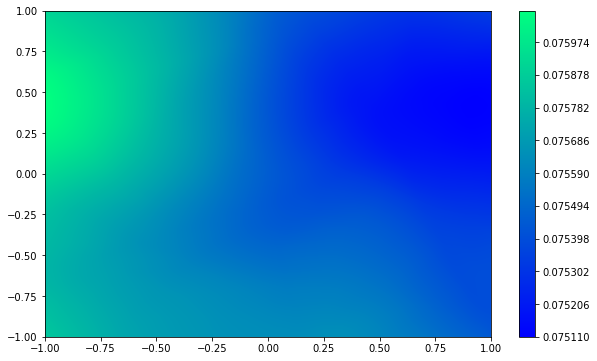

In [71]:
x_mesh = torch.linspace(down, up, 500, requires_grad=True)
mesh1, mesh2 = torch.meshgrid(x_mesh, x_mesh)
mesh_1 = torch.reshape(mesh1, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
mesh_2 = torch.reshape(mesh2, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
t = torch.linspace(0, 1, 11).unsqueeze(1).view(1, -1).repeat(250000, 1).unsqueeze(2).view(-1, 1, 11)
xt_comparison = torch.cat((mesh_1, mesh_2, t), dim=1)

u_net = discriminator(config)

error = torch.sqrt(torch.square(u_net(xt_comparison[:, 0, :], xt_comparison[:, 1, :], xt_comparison[:, 2, :]).squeeze(2)))
mean_error = torch.mean(error, dim=1)
mean_error = mean_error.view(500, 500)

plt.figure(figsize=(10,6))

cset=plt.contourf(mesh1.data.numpy(),mesh2.data.numpy(),mean_error.data.numpy(), 500, cmap='winter')

plt.colorbar(cset)
plt.show()

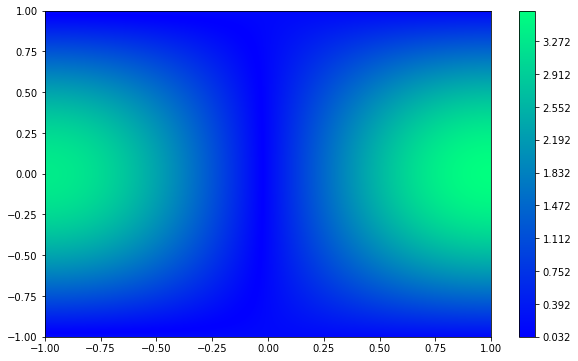

In [63]:
x_mesh = torch.linspace(down, up, 500, requires_grad=True)
mesh1, mesh2 = torch.meshgrid(x_mesh, x_mesh)
mesh_1 = torch.reshape(mesh1, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
mesh_2 = torch.reshape(mesh2, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
t = torch.linspace(0, 1, 11).unsqueeze(1).view(1, -1).repeat(250000, 1).unsqueeze(2).view(-1, 1, 11)
xt_comparison = torch.cat((mesh_1, mesh_2, t), dim=1)

u_net = generator(config)

error = torch.sqrt(torch.square(func_u_sol(xt_comparison)-u_net(xt_comparison[:, 0, :], xt_comparison[:, 1, :], xt_comparison[:, 2, :]).squeeze(2)))
mean_error = torch.mean(error, dim=1)
mean_error = mean_error.view(500, 500)

plt.figure(figsize=(10,6))

cset=plt.contourf(mesh1.data.numpy(),mesh2.data.numpy(),mean_error.data.numpy(), 500, cmap='winter')

plt.colorbar(cset)
plt.show()

### increasing coefs to 10^5

In [45]:
if __name__ == '__main__':

    n1 = config['n1']
    n2 = config['n2']
    
    iteration=config['iteration']
    nn=config['subiteration']
    
    # neural network models
    u_net = generator(config).to(device)
    v_net = discriminator(config).to(device)
    
    
    # optimizers for WAN
    optimizer_u = torch.optim.Adam(u_net.parameters(), lr=config['u_rate'])
    optimizer_v = torch.optim.Adam(v_net.parameters(), lr=config['v_rate'])

    #scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_u, factor=0.5, patience=30)
    #scheduler_v = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_v, factor=0.5, patience=30)

    prediction_u = u_net(xu, yu, tu)
    prediction_v = v_net(xv, yv, tv)

    Loss = 0
                
    for k in range(iteration):
        
        
        for i in range(n1):
            
            loss_u = Loss_u(prediction_u, prediction_v, u_net, config['alpha'], config['alpha'])
            
            optimizer_u.zero_grad()
            loss_u.backward(retain_graph=True)
            try:
                optimizer_u.step()
            except TypeError:
                print("this opt_u step is wrong")
            #scheduler_u.step(loss_u)
            prediction_u = u_net(xu, yu, tu)            

        for j in range(n2):
            loss_v = Loss_v(prediction_u, prediction_v)
            
            optimizer_v.zero_grad()
            loss_v.backward(retain_graph=True)
            try:
                optimizer_v.step()
            except TypeError:
                print("this opt_v step is wrong")
                
            #scheduler_v.step(loss_v)
            prediction_v = v_net(xv, yv, tv)
#             print('v',k,i,torch.isnan(prediction_v).any()) #sanity check



        if k % nn == 0:
            print(k, loss_u.data.item(), loss_v.data.item())
            error_test = torch.mean(
                torch.sqrt(torch.square((func_u_sol(xt_domain_train) - prediction_u.data.squeeze(2))))).data
            print("error test " + str(error_test))
                
        del loss_u, loss_v
        torch.cuda.empty_cache()

0 735607.375 -5.792511940002441
error test tensor(1.4187, device='cuda:0')
10 695745.375 -11.096324920654297
error test tensor(1.3577, device='cuda:0')
20 416081.03125 -4.3065314292907715
error test tensor(0.9946, device='cuda:0')
30 225120.046875 -5.39694881439209
error test tensor(0.9196, device='cuda:0')
40 195873.5 -6.22808837890625
error test tensor(0.9596, device='cuda:0')
50 192752.953125 -6.335755348205566
error test tensor(1.0052, device='cuda:0')
60 191184.203125 -6.306792259216309
error test tensor(1.0440, device='cuda:0')
70 189941.34375 -3.5988807678222656
error test tensor(1.0729, device='cuda:0')
80 189211.28125 -7.47189474105835
error test tensor(1.0957, device='cuda:0')
90 188648.296875 -6.956716060638428
error test tensor(1.1154, device='cuda:0')
100 188115.78125 -4.643067359924316
error test tensor(1.1363, device='cuda:0')
110 187804.34375 -6.118175506591797
error test tensor(1.1445, device='cuda:0')
120 187481.109375 -8.767807960510254
error test tensor(1.1589, devi

1040 182278.078125 -2.2576045989990234
error test tensor(1.2980, device='cuda:0')
1050 182802.453125 -2.2643251419067383
error test tensor(1.2973, device='cuda:0')
1060 182684.171875 -2.2511157989501953
error test tensor(1.3008, device='cuda:0')
1070 182347.765625 -2.33563232421875
error test tensor(1.3047, device='cuda:0')
1080 182406.078125 -2.230250358581543
error test tensor(1.2969, device='cuda:0')
1090 182337.5625 -2.2844972610473633
error test tensor(1.3021, device='cuda:0')
1100 182265.53125 -2.261906623840332
error test tensor(1.2989, device='cuda:0')
1110 182434.25 -2.2853307723999023
error test tensor(1.3033, device='cuda:0')
1120 182434.234375 -2.3648338317871094
error test tensor(1.3050, device='cuda:0')
1130 182218.609375 -2.2586374282836914
error test tensor(1.2991, device='cuda:0')
1140 182256.5 -2.3006324768066406
error test tensor(1.3003, device='cuda:0')
1150 182042.84375 -2.3133630752563477
error test tensor(1.3018, device='cuda:0')
1160 182983.765625 -2.34317779541

2060 181597.90625 -2.462207794189453
error test tensor(1.3099, device='cuda:0')
2070 183673.59375 -2.5395021438598633
error test tensor(1.3168, device='cuda:0')
2080 181571.8125 -2.465847969055176
error test tensor(1.3097, device='cuda:0')
2090 183824.34375 -2.53891658782959
error test tensor(1.3177, device='cuda:0')
2100 181539.125 -2.4889793395996094
error test tensor(1.3094, device='cuda:0')
2110 181821.21875 -2.5153322219848633
error test tensor(1.3130, device='cuda:0')
2120 181581.234375 -2.476011276245117
error test tensor(1.3093, device='cuda:0')
2130 182525.359375 -2.419163703918457
error test tensor(1.3033, device='cuda:0')
2140 181608.375 -2.5163402557373047
error test tensor(1.3115, device='cuda:0')
2150 181759.796875 -2.452561378479004
error test tensor(1.3070, device='cuda:0')
2160 181970.15625 -2.4110984802246094
error test tensor(1.3019, device='cuda:0')
2170 181521.53125 -2.5175018310546875
error test tensor(1.3100, device='cuda:0')
2180 181707.984375 -2.459281921386718

3080 181291.734375 -2.4772891998291016
error test tensor(1.3085, device='cuda:0')
3090 181331.890625 -2.534022331237793
error test tensor(1.3098, device='cuda:0')
3100 181498.453125 -2.4819459915161133
error test tensor(1.3061, device='cuda:0')
3110 181683.3125 -2.518115997314453
error test tensor(1.3057, device='cuda:0')
3120 182070.5 -2.474452018737793
error test tensor(1.3049, device='cuda:0')
3130 184865.421875 -2.526622772216797
error test tensor(1.3090, device='cuda:0')
3140 181700.015625 -2.497164726257324
error test tensor(1.3038, device='cuda:0')
3150 181232.0625 -2.510342597961426
error test tensor(1.3073, device='cuda:0')
3160 181225.421875 -2.533231735229492
error test tensor(1.3092, device='cuda:0')
3170 181220.078125 -2.525257110595703
error test tensor(1.3090, device='cuda:0')
3180 181226.453125 -2.5037498474121094
error test tensor(1.3080, device='cuda:0')
3190 181272.1875 -2.5374937057495117
error test tensor(1.3102, device='cuda:0')
3200 181569.65625 -2.56252670288085

4100 181082.640625 -2.555509567260742
error test tensor(1.3097, device='cuda:0')
4110 181679.609375 -2.589723587036133
error test tensor(1.3084, device='cuda:0')
4120 181102.59375 -2.5748729705810547
error test tensor(1.3092, device='cuda:0')
4130 181060.171875 -2.5863723754882812
error test tensor(1.3107, device='cuda:0')
4140 181801.046875 -2.5081348419189453
error test tensor(1.3070, device='cuda:0')
4150 181254.34375 -2.559366226196289
error test tensor(1.3102, device='cuda:0')
4160 181222.203125 -2.5638790130615234
error test tensor(1.3084, device='cuda:0')
4170 181433.046875 -2.6203651428222656
error test tensor(1.3125, device='cuda:0')
4180 181314.46875 -2.571361541748047
error test tensor(1.3106, device='cuda:0')
4190 181073.859375 -2.5920276641845703
error test tensor(1.3116, device='cuda:0')
4200 181081.34375 -2.5896244049072266
error test tensor(1.3119, device='cuda:0')
4210 181219.84375 -2.599557876586914
error test tensor(1.3137, device='cuda:0')
4220 181201.296875 -2.5698

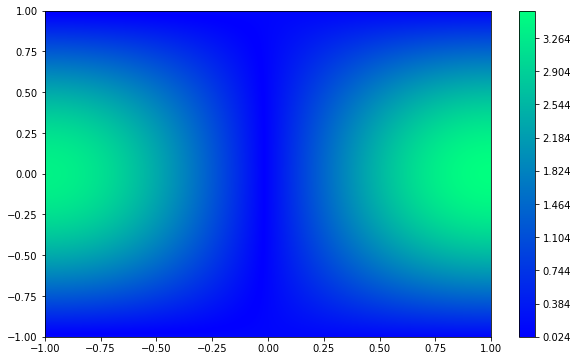

In [46]:
x_mesh = torch.linspace(down, up, 500, requires_grad=True)
mesh1, mesh2 = torch.meshgrid(x_mesh, x_mesh)
mesh_1 = torch.reshape(mesh1, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
mesh_2 = torch.reshape(mesh2, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
t = torch.linspace(0, 1, 11).unsqueeze(1).view(1, -1).repeat(250000, 1).unsqueeze(2).view(-1, 1, 11)
xt_comparison = torch.cat((mesh_1, mesh_2, t), dim=1)

u_net = generator(config)

error = torch.sqrt(torch.square(func_u_sol(xt_comparison)-u_net(xt_comparison[:, 0, :], xt_comparison[:, 1, :], xt_comparison[:, 2, :]).squeeze(2)))
mean_error = torch.mean(error, dim=1)
mean_error = mean_error.view(500, 500)

plt.figure(figsize=(10,6))

cset=plt.contourf(mesh1.data.numpy(),mesh2.data.numpy(),mean_error.data.numpy(), 500, cmap='winter')

plt.colorbar(cset)
plt.show()

In [19]:
func_u_sol(xt_domain_train)

tensor([[ 0.1742,  0.1925,  0.2128,  ...,  0.3877,  0.4285,  0.4736],
        [-1.3258, -1.4652, -1.6194,  ..., -2.9506, -3.2610, -3.6039],
        [ 0.9244,  1.0216,  1.1290,  ...,  2.0572,  2.2736,  2.5127],
        ...,
        [-1.5309, -1.6920, -1.8699,  ..., -3.4072, -3.7655, -4.1615],
        [ 1.4966,  1.6540,  1.8279,  ...,  3.3307,  3.6810,  4.0681],
        [-1.2394, -1.3697, -1.5138,  ..., -2.7582, -3.0483, -3.3689]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [23]:
torch.sum(torch.sqrt(torch.square((func_u_sol(xt_domain_train) - prediction_u.data.squeeze(2))))[:,-1])

tensor(605.1740, device='cuda:0', grad_fn=<SumBackward0>)

In [18]:
prediction_u.data[0]

tensor([[0.1868],
        [0.2433],
        [0.2936],
        [0.3456],
        [0.3970],
        [0.4839],
        [0.6553],
        [0.8420],
        [1.0176],
        [1.1842],
        [1.3866]], device='cuda:0')

In [17]:
prediction_u.data.squeeze(2)

tensor([[ 0.1868,  0.2433,  0.2936,  ...,  1.0176,  1.1842,  1.3866],
        [-1.2730, -1.3104, -1.3340,  ..., -0.8007, -0.5333, -0.0997],
        [ 0.9705,  1.0138,  1.0567,  ...,  1.8277,  2.0570,  2.4086],
        ...,
        [-1.5816, -1.7250, -1.8633,  ..., -2.3486, -2.1082, -1.5840],
        [ 1.4619,  1.5661,  1.6652,  ...,  2.9367,  3.2356,  3.5894],
        [-1.2497, -1.4226, -1.5633,  ..., -1.9967, -2.0094, -1.8614]],
       device='cuda:0')

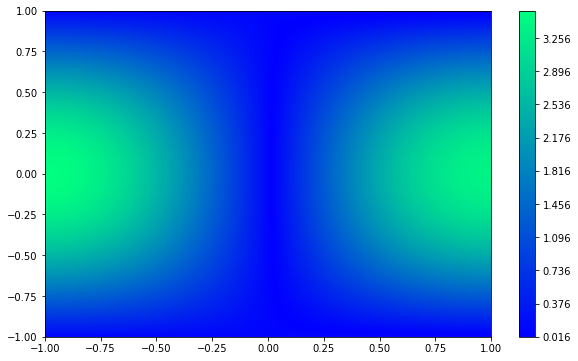

In [15]:
x_mesh = torch.linspace(down, up, 500, requires_grad=True)
mesh1, mesh2 = torch.meshgrid(x_mesh, x_mesh)
mesh_1 = torch.reshape(mesh1, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
mesh_2 = torch.reshape(mesh2, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
t = torch.linspace(0, 1, 11).unsqueeze(1).view(1, -1).repeat(250000, 1).unsqueeze(2).view(-1, 1, 11)
xt_comparison = torch.cat((mesh_1, mesh_2, t), dim=1)

u_net = generator(config)

error = torch.sqrt(torch.square(func_u_sol(xt_comparison)-u_net(xt_comparison[:, 0, :], xt_comparison[:, 1, :], xt_comparison[:, 2, :]).squeeze(2)))
mean_error = torch.mean(error, dim=1)
mean_error = mean_error.view(500, 500)

plt.figure(figsize=(10,6))

cset=plt.contourf(mesh1.data.numpy(),mesh2.data.numpy(),mean_error.data.numpy(), 500, cmap='winter')

plt.colorbar(cset)
plt.show()

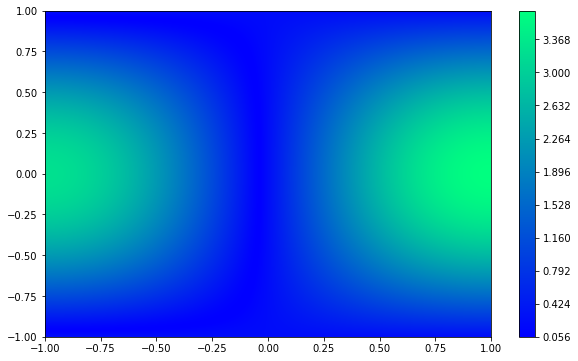

In [9]:
x_mesh = torch.linspace(down, up, 500, requires_grad=True)
mesh1, mesh2 = torch.meshgrid(x_mesh, x_mesh)
mesh_1 = torch.reshape(mesh1, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
mesh_2 = torch.reshape(mesh2, [-1, 1]).repeat(1, 11).unsqueeze(2).view(-1, 1, 11)
t = torch.linspace(0, 1, 11).unsqueeze(1).view(1, -1).repeat(250000, 1).unsqueeze(2).view(-1, 1, 11)
xt_comparison = torch.cat((mesh_1, mesh_2, t), dim=1)

u_net = generator(config)

error = torch.sqrt(torch.square(func_u_sol(xt_comparison)-u_net(xt_comparison[:, 0, :], xt_comparison[:, 1, :], xt_comparison[:, 2, :]).squeeze(2)))
mean_error = torch.mean(error, dim=1)
mean_error = mean_error.view(500, 500)

plt.figure(figsize=(10,6))

cset=plt.contourf(mesh1.data.numpy(),mesh2.data.numpy(),mean_error.data.numpy(), 500, cmap='winter')

plt.colorbar(cset)
plt.show()